## 1. Setup and Data Loading <a id="1-setup"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [2]:
# Define paths
human_data_dir = Path("../data/humnan-annotator-results")
llm_data_dir = Path("../data/llm-annotator-results")

# Load human annotators
human_annotators = ['A', 'B', 'C']
human_data = {}
for annotator in human_annotators:
    file_path = human_data_dir / f'annotations_{annotator}.csv'
    df = pd.read_csv(file_path)
    human_data[annotator] = df
    print(f"✓ Loaded human {annotator}: {len(df)} annotations")

# Load LLM annotators from all rounds
llm_data = {}

# Scan all round folders (r1, r2, etc.)
for round_folder in sorted(llm_data_dir.iterdir()):
    if not round_folder.is_dir():
        continue
    
    # To manually exclude certain rounds, uncomment and modify the following line:
    if round_folder.name  in ['r2', 'r3']:
        continue
    
    round_name = round_folder.name
    print(f"\n📁 Processing round: {round_name}")
    
    # Load all CSV files in this round
    for csv_file in sorted(round_folder.glob("annotations_*.csv")):
        # Extract LLM name from filename: annotations_ollama_model_name.csv
        # Keep underscores, don't replace with spaces
        base_llm_name = csv_file.stem.replace('annotations_ollama_', '')
        
        # Add round suffix with underscore (no spaces, no parentheses)
        llm_name_with_round = f"{base_llm_name}_{round_name}"
        
        # Load dataframe
        df = pd.read_csv(csv_file)
        
        # CRITICAL: Store with round-suffixed name as key to avoid overwriting
        llm_data[llm_name_with_round] = df
        print(f"  ✓ Loaded {llm_name_with_round}: {len(df)} annotations")

# Create list of all LLM annotator names
llm_annotators = list(llm_data.keys())

print(f"\n{'='*80}")
print(f"SUMMARY")
print(f"{'='*80}")
print(f"Human annotators: {len(human_annotators)}")
print(f"LLM annotators: {len(llm_annotators)}")
print(f"Total annotators: {len(human_annotators) + len(llm_annotators)}")
print(f"\nLLM models loaded:")
for llm in sorted(llm_annotators):
    print(f"  - {llm}")
print(f"{'='*80}")

✓ Loaded human A: 911 annotations
✓ Loaded human B: 1000 annotations
✓ Loaded human C: 911 annotations

📁 Processing round: r1
  ✓ Loaded codellama_13b_r1: 50 annotations
  ✓ Loaded deepseek-r1_14b_r1: 50 annotations
  ✓ Loaded gemma3_12b_r1: 50 annotations
  ✓ Loaded gpt-oss_20b_r1: 50 annotations
  ✓ Loaded llama3.1_8b_r1: 50 annotations
  ✓ Loaded mistral_7b_r1: 50 annotations
  ✓ Loaded qwen3-coder_30b_r1: 50 annotations

SUMMARY
Human annotators: 3
LLM annotators: 7
Total annotators: 10

LLM models loaded:
  - codellama_13b_r1
  - deepseek-r1_14b_r1
  - gemma3_12b_r1
  - gpt-oss_20b_r1
  - llama3.1_8b_r1
  - mistral_7b_r1
  - qwen3-coder_30b_r1


In [3]:
# Define categories and create unified dataset
categories = ['bfc', 'bpc', 'prc', 'nfc']

def prepare_unified_data(human_data, llm_data, categories):
    """
    Create a unified dataset with all annotations.
    Returns a dictionary: {category: DataFrame with columns [hash, A, B, C, llm1, llm2, ...]}
    """
    unified = {}
    
    for category in categories:
        # Start with human annotations
        category_df = human_data['A'][['hash', category]].rename(columns={category: 'A'}).copy()
        
        # Add human annotator columns
        for annotator in ['B', 'C']:
            df = human_data[annotator]
            category_df = category_df.merge(
                df[['hash', category]].rename(columns={category: annotator}),
                on='hash',
                how='inner'
            )
        
        # Add LLM columns
        for llm_name, df in llm_data.items():
            category_df = category_df.merge(
                df[['hash', category]].rename(columns={category: llm_name}),
                on='hash',
                how='inner'
            )
        
        # Drop rows with missing values (should not be needed with inner joins, but as safety)
        category_df = category_df.dropna()
        unified[category] = category_df
        
        print(f"{category.upper()}: {len(category_df)} commits with complete annotations")
    
    return unified

unified_data = prepare_unified_data(human_data, llm_data, categories)

BFC: 50 commits with complete annotations
BPC: 50 commits with complete annotations
PRC: 50 commits with complete annotations
NFC: 50 commits with complete annotations


### Epsilon (ε) Selection: Cost-Benefit Hyperparameter

Before proceeding with the analysis, we need to set the **cost-benefit hyperparameter ε**, which adjusts the threshold the LLM must exceed in the alt-test.

#### Why Use ε > 0?

LLMs offer a **cheaper, faster, and less labor-intensive** alternative to human annotators. The hyperparameter ε accounts for this advantage by lowering the threshold the LLM must beat (ρ^h_j - ε instead of ρ^h_j).

#### Rule of Thumb for Setting ε:

1. **ε = 0.2**: For trusted experts or highly reliable annotators
2. **ε = 0.15**: For skilled annotators (e.g., undergraduate students, trained workers)
3. **ε = 0.1**: For crowd workers or annotators with low reliability

#### Effective Range:
- **ε > 0.3**: Almost all LLMs pass (too lenient)
- **0.05 ≤ ε ≤ 0.3**: Effective range with meaningful discrimination
- **ε < 0.05**: Almost all LLMs fail (too strict)

#### Our Choice:

**ε = 0.15** (skilled annotators)

**Justification**:
- Human annotators in this study are graduate-level researchers
- They received training on commit classification methodology
- The annotation task requires domain knowledge (software engineering, Linux kernel)
- This is not a simple task for untrained crowd workers
- Moderate IAA suggests skilled but not expert-level annotators

We will also test **ε = 0.1** and **ε = 0.2** for sensitivity analysis.

In [4]:
# Configuration: Epsilon values to test
EPSILON_PRIMARY = 0.15  # Primary epsilon for skilled annotators
EPSILON_SENSITIVITY = [0.0, 0.05, 0.1, 0.15, 0.2]  # Sensitivity analysis
ALPHA = 0.05  # Significance level

print(f"Primary epsilon (ε): {EPSILON_PRIMARY}")
print(f"Sensitivity analysis: ε ∈ {EPSILON_SENSITIVITY}")
print(f"Significance level (α): {ALPHA}")
print(f"\nJustification: Graduate-level researchers with training (skilled annotators)")
print(f"              → ε = {EPSILON_PRIMARY} is appropriate")

Primary epsilon (ε): 0.15
Sensitivity analysis: ε ∈ [0.0, 0.05, 0.1, 0.15, 0.2]
Significance level (α): 0.05

Justification: Graduate-level researchers with training (skilled annotators)
              → ε = 0.15 is appropriate


In [5]:
# Display sample data
print("\nSample data for BFC category:")
display(unified_data['bfc'].head())

print("\nDataset shapes:")
for cat in categories:
    print(f"{cat.upper()}: {unified_data[cat].shape}")


Sample data for BFC category:


,hash,A,B,C,codellama_13b_r1,deepseek-r1_14b_r1,gemma3_12b_r1,gpt-oss_20b_r1,llama3.1_8b_r1,mistral_7b_r1,qwen3-coder_30b_r1
0,3044a4f271,0,0,0,0,0,0,0,0,0,0
1,e1553351d7,0,0,0,4,0,0,0,0,0,0
2,2fadc6ea4a,0,0,0,0,0,0,0,0,0,0
3,805a3ebed5,0,0,0,0,0,0,0,0,0,0
4,9b51d9d866,0,0,0,0,0,0,0,0,0,0



Dataset shapes:
BFC: (50, 11)
BPC: (50, 11)
PRC: (50, 11)
NFC: (50, 11)


## 2. Scoring Functions <a id="2-scoring"></a>

We'll use **negative RMSE** as it's more appropriate for ordinal Likert scales.

### Negative RMSE
For continuous/ordinal annotations:
$$-RMSE(f, x_i, j) = - \sqrt{\frac{1}{|H_i| - 1} \sum_{k \in H_i[-j]} (f(x_i) - h_k(x_i))^2}$$

In [6]:
def compute_rmse_score(f_annotation, other_annotations):
    """
    Compute negative RMSE alignment score.
    
    Args:
        f_annotation: Single annotation value (from LLM or excluded human)
        other_annotations: Array of annotations from other humans
    
    Returns:
        Negative RMSE score (higher is better)
    """
    return -np.sqrt(np.mean((f_annotation - other_annotations) ** 2))

# Test the scoring function
test_f = 3
test_others = np.array([4, 3])
print(f"Test annotation: f={test_f}, others={test_others}")
print(f"RMSE score: {compute_rmse_score(test_f, test_others):.3f}")

Test annotation: f=3, others=[4 3]
RMSE score: -0.707


## 3. Advantage Probability Computation <a id="3-advantage"></a>

We compute advantage probabilities using the leave-one-out approach:

### For each instance $x_i$ and excluded annotator $h_j$:

1. Compute $S(f, x_i, j)$: LLM's alignment with remaining humans
2. Compute $S(h_j, x_i, j)$: Excluded human's alignment with remaining humans
3. Define indicator:
$$W^{f}_{i,j} = \begin{cases} 1, & \text{if } S(f, x_i, j) \geq S(h_j, x_i, j) \\ 0, & \text{otherwise} \end{cases}$$

4. Estimate advantage probability:
$$\rho^f_j = \frac{1}{|I_j|} \sum_{i \in I_j} W^{f}_{i,j}$$

In [7]:
def compute_advantage_probabilities(df, llm_name, human_annotators, score_func=compute_rmse_score):
    """
    Compute advantage probabilities for a single LLM against all human annotators.
    
    Args:
        df: DataFrame with columns [hash, A, B, C, llm_name]
        llm_name: Name of the LLM column
        human_annotators: List of human annotator names
        score_func: Scoring function to use (compute_rmse_score or compute_acc_score)
    
    Returns:
        Dictionary with results for each excluded human:
        {human_j: {'rho_f': prob_llm_wins, 'rho_h': prob_human_wins, 'W_f': indicators_llm, 'W_h': indicators_human}}
    """
    results = {}
    
    for excluded_human in human_annotators:
        # Get remaining humans
        remaining_humans = [h for h in human_annotators if h != excluded_human]
        
        W_f_list = []  # Indicators for LLM winning
        W_h_list = []  # Indicators for human winning
        
        # For each instance (commit)
        for idx, row in df.iterrows():
            # Get annotations
            llm_annotation = row[llm_name]
            excluded_annotation = row[excluded_human]
            remaining_annotations = row[remaining_humans].values
            
            # Compute alignment scores
            S_llm = score_func(llm_annotation, remaining_annotations)
            S_human = score_func(excluded_annotation, remaining_annotations)
            
            # Compute indicators
            W_f = 1 if S_llm >= S_human else 0
            W_h = 1 if S_human >= S_llm else 0
            
            W_f_list.append(W_f)
            W_h_list.append(W_h)
        
        # Compute advantage probabilities
        rho_f = np.mean(W_f_list)
        rho_h = np.mean(W_h_list)
        
        results[excluded_human] = {
            'rho_f': rho_f,
            'rho_h': rho_h,
            'W_f': W_f_list,
            'W_h': W_h_list,
            'n_instances': len(W_f_list)
        }
    
    return results

In [8]:
# Test advantage probability computation for BFC category with one LLM
test_llm = list(llm_data.keys())[4]
test_results = compute_advantage_probabilities(
    unified_data['bfc'], 
    test_llm, 
    human_annotators
)

print(f"\nTest results for {test_llm} on BFC category:")
for human, res in test_results.items():
    print(f"  vs {human}: ρ^f={res['rho_f']:.3f}, ρ^h={res['rho_h']:.3f}, n={res['n_instances']}")


Test results for llama3.1_8b_r1 on BFC category:
  vs A: ρ^f=0.920, ρ^h=0.980, n=50
  vs B: ρ^f=0.920, ρ^h=0.960, n=50
  vs C: ρ^f=0.920, ρ^h=0.980, n=50


## 4. Statistical Testing <a id="4-testing"></a>

### Hypothesis Testing with Sign Test

We test the hypothesis:
$$H_{0j}: \rho^f_j \leq \rho^h_j - \epsilon \quad \text{vs.} \quad H_{1j}: \rho^f_j > \rho^h_j - \epsilon$$

Using difference indicators: $d_{i,j} = W^{h}_{i,j} - W^{f}_{i,j}$

Since $\rho^h - \rho^f = E[d]$, the hypothesis can be equivalently written as:
$$H_{0j}: E[d_j] \geq \epsilon \quad \text{vs.} \quad H_{1j}: E[d_j] < \epsilon$$

This means we test whether the expected difference in advantage probabilities is at least $\epsilon$ (human is better), or less than $\epsilon$ (LLM is practically equivalent or better).

### Sign Test Implementation

The **Sign Test** counts the number of observations where $d_{i,j} > \epsilon$ vs. $d_{i,j} < \epsilon$:
- $n_{positive} = \sum_{i=1}^{n} \mathbb{1}(d_{i,j} > \epsilon)$ (human clearly wins)
- $n_{negative} = \sum_{i=1}^{n} \mathbb{1}(d_{i,j} < \epsilon)$ (LLM wins or ties)

Under $H_0$, we expect $P(d < \epsilon) \leq 0.5$. We use a binomial test to check if $n_{negative}$ is significantly greater than expected by chance, which would provide evidence for $H_1$ (LLM is practically equivalent or better).

**Why Sign Test?**

The Sign Test is appropriate for this analysis because:
1. **Ordinal data handling**: It only requires ordinal information (direction of differences), not interval scale assumptions
2. **Robust to ties**: It handles the high proportion of tied observations in our data without violating test assumptions
3. **Correct epsilon application**: Epsilon is applied as a threshold for comparison, not subtracted from ordinal categories
4. **Clear interpretation**: Counts observations where LLM wins/ties vs. human wins beyond the epsilon margin
5. **No distribution assumptions**: Non-parametric test that doesn't assume normal or symmetric distributions

### Benjamini-Yekutieli (BY) Correction

Since we test multiple LLMs against multiple humans, we apply the **Benjamini-Yekutieli** procedure to control the False Discovery Rate (FDR) at α = 0.05. This method is valid even when tests are dependent (as they are in our leave-one-out design).

In [9]:
def benjamini_yekutieli_correction(p_values, alpha=0.05):
    """
    Apply Benjamini-Yekutieli correction for FDR control.
    
    Uses statsmodels multipletests with 'fdr_by' method.
    
    Args:
        p_values: Array of p-values
        alpha: Significance level (default: 0.05)
    
    Returns:
        Array of boolean values indicating rejected hypotheses
    """
    rejected, _, _, _ = multipletests(p_values, alpha=alpha, method='fdr_by')
    return rejected

def perform_alt_test(advantage_results, epsilon=0.0, alpha=0.05):
    """
    Perform the Alternative Annotator Test with BY correction.
    
    Uses Sign Test (non-parametric) which is more appropriate for ordinal
    categories {-1, 0, 1} and robust to ties.
    
    H₀: ρ^f ≤ ρ^h - ε  (LLM is NOT better than human, adjusted by cost-benefit ε)
    H₁: ρ^f > ρ^h - ε  (LLM IS better than human, adjusted by cost-benefit ε)
    
    Args:
        advantage_results: Results from compute_advantage_probabilities
        epsilon: Cost-benefit hyperparameter applied to probabilities (default: 0.0)
        alpha: Significance level (default: 0.05)
    
    Returns:
        Dictionary with test results
    """
    test_results = {}
    p_values_list = []
    human_list = []
    
    for human, res in advantage_results.items():
        # Compute differences: d_i,j = W^h_i,j - W^f_i,j ∈ {-1, 0, 1}
        d = np.array(res['W_h']) - np.array(res['W_f'])
        n = len(d)
        
        # Compute empirical advantage probabilities
        rho_f = res['rho_f']  # P(LLM wins)
        rho_h = res['rho_h']  # P(Human wins)
        
        # Apply epsilon to the probability level 
        # H₀: ρ^f ≤ ρ^h - ε  ⟺  ρ^f - ρ^h ≤ -ε  ⟺  ρ^h - ρ^f ≥ ε
        # Equivalently for differences: E[d] ≥ ε (since E[d] = ρ^h - ρ^f)
        
        # Sign Test: Test if median(d) ≥ ε
        # Count positive and negative differences relative to ε
        n_positive = np.sum(d > epsilon)   # d > ε (human clearly wins)
        n_negative = np.sum(d < epsilon)   # d < ε (LLM wins or ties)
        n_ties = np.sum(d == epsilon)      # d = ε (boundary case)
        
        # Sign test statistic: number of times d < ε
        # Under H₀, this should be around n/2 (binomial with p=0.5)
        # We want to reject H₀ if there are too many cases where d < ε (LLM is better)
        
        # Use binomial test: P(X ≤ n_negative) where X ~ Binomial(n_positive + n_negative, 0.5)
        n_total = n_positive + n_negative  # Exclude exact ties at ε
        
        if n_total == 0:
            # All values are exactly at epsilon (extremely unlikely)
            p_value = 0.5
            test_stat = 0
        else:
            # One-tailed binomial test
            # H₁: P(d < ε) > 0.5, i.e., LLM is better
            binomial_result = stats.binomtest(n_negative, n_total, p=0.5, alternative='greater')
            p_value = binomial_result.pvalue
            test_stat = n_negative
        
        test_used = 'sign_test'

        
        # Compute sample statistics
        d_bar = np.mean(d)
        s = np.std(d, ddof=1)
        
        test_results[human] = {
            'rho_f': rho_f,
            'rho_h': rho_h,
            'rho_diff': rho_f - rho_h,  # Difference in probabilities
            'd_bar': d_bar,
            's': s,
            'test_used': test_used,
            'test_stat': test_stat,
            'p_value': p_value,
            'n': n,
            'n_positive': np.sum(d > epsilon),
            'n_negative': np.sum(d < epsilon),
            'n_ties': np.sum(d == epsilon),
        }
        
        p_values_list.append(p_value)
        human_list.append(human)
    
    # Apply BY correction
    p_values_array = np.array(p_values_list)
    rejected = benjamini_yekutieli_correction(p_values_array, alpha)
    
    # Add rejection information
    for i, human in enumerate(human_list):
        test_results[human]['rejected'] = rejected[i]
    
    # Compute winning rate
    winning_rate = np.mean(rejected)
    
    # Compute average advantage probability
    avg_advantage_prob = np.mean([res['rho_f'] for res in test_results.values()])
    
    return {
        'test_results': test_results,
        'winning_rate': winning_rate,
        'avg_advantage_prob': avg_advantage_prob,
        'can_replace': winning_rate >= 0.5
    }


In [10]:
# Test the alt-test with one LLM on BFC
test_alt_results = perform_alt_test(test_results, epsilon=EPSILON_PRIMARY, alpha=ALPHA)

print(f"\nAlt-Test results for {test_llm} on BFC (ε={EPSILON_PRIMARY}):")
print(f"  Winning Rate (ω): {test_alt_results['winning_rate']:.3f}")
print(f"  Avg Advantage Prob (ρ): {test_alt_results['avg_advantage_prob']:.3f}")
print(f"  Can replace humans: {test_alt_results['can_replace']}")
print("\nDetailed results:")
for human, res in test_alt_results['test_results'].items():
    sign_info = ""
    if res['test_used'] == 'sign_test':
        sign_info = f" | Signs: d<ε={res['n_negative']}, d>ε={res['n_positive']}, d=ε={res['n_ties']}"
    
    print(f"  vs {human}: ρ^f={res['rho_f']:.3f}, ρ^h={res['rho_h']:.3f}, "
          f"p={res['p_value']:.4f}, test={res['test_used']}, rejected={res['rejected']}{sign_info}")


Alt-Test results for llama3.1_8b_r1 on BFC (ε=0.15):
  Winning Rate (ω): 1.000
  Avg Advantage Prob (ρ): 0.920
  Can replace humans: True

Detailed results:
  vs A: ρ^f=0.920, ρ^h=0.980, p=0.0000, test=sign_test, rejected=True | Signs: d<ε=46, d>ε=4, d=ε=0
  vs B: ρ^f=0.920, ρ^h=0.960, p=0.0000, test=sign_test, rejected=True | Signs: d<ε=46, d>ε=4, d=ε=0
  vs C: ρ^f=0.920, ρ^h=0.980, p=0.0000, test=sign_test, rejected=True | Signs: d<ε=46, d>ε=4, d=ε=0


In [11]:
# Detailed hypothesis test results for one LLM (example)
print(f"\n{'='*100}")
print(f"DETAILED HYPOTHESIS TEST RESULTS: {test_llm} on BFC")
print(f"{'='*100}\n")

for human, res in test_alt_results['test_results'].items():
    print(f"\n{'-'*100}")
    print(f"Testing {test_llm} vs Human {human}")
    print(f"{'-'*100}")
    
    # Basic statistics
    print(f"\n1. ADVANTAGE PROBABILITIES:")
    print(f"   ρ^f (LLM advantage):     {res['rho_f']:.4f}  → LLM wins in {res['rho_f']*100:.1f}% of commits")
    print(f"   ρ^h (Human advantage):   {res['rho_h']:.4f}  → Human wins in {res['rho_h']*100:.1f}% of commits")
    print(f"   Difference (ρ^f - ρ^h):  {res['rho_diff']:.4f}")
    
    # Sample statistics
    print(f"\n2. SAMPLE STATISTICS (differences d = W^h - W^f):")
    print(f"   Sample size (n):         {res['n']}")
    print(f"   Mean difference (d̄):     {res['d_bar']:.4f}")
    print(f"   Std deviation (s):       {res['s']:.4f}")
    print(f"   Possible values:         {{-1, 0, 1}}")
    
    # Sign test details
    if res['test_used'] == 'sign_test':
        print(f"\n3. SIGN TEST DISTRIBUTION:")
        print(f"   d > ε (Human wins):      {res['n_positive']} commits ({res['n_positive']/res['n']*100:.1f}%)")
        print(f"   d < ε (LLM wins/ties):   {res['n_negative']} commits ({res['n_negative']/res['n']*100:.1f}%)")
        print(f"   d = ε (Exact ties):      {res['n_ties']} commits ({res['n_ties']/res['n']*100:.1f}%)")
        print(f"   Note: ε = {EPSILON_PRIMARY} applied at probability level")
    
    # Hypothesis test
    print(f"\n4. HYPOTHESIS TEST:")
    print(f"   Test used:               {res['test_used'].replace('_', ' ').title()}")
    print(f"   H₀:                      ρ^f ≤ ρ^h - ε  (LLM is NOT better, adjusted by ε={EPSILON_PRIMARY})")
    print(f"   H₁:                      ρ^f > ρ^h - ε  (LLM IS better)")
    print(f"   Test statistic:          {res['test_stat']}")
    print(f"   p-value (raw):           {res['p_value']:.6f}")
    print(f"   Significance level (α):  {ALPHA}")
    
    # Interpretation
    print(f"\n5. INTERPRETATION:")
    if res['p_value'] < ALPHA:
        print(f"   ✓ p-value ({res['p_value']:.6f}) < α ({ALPHA})")
        print(f"   ✓ Reject H₀: Strong evidence that LLM is better than human (adjusted by ε)")
    else:
        print(f"   ✗ p-value ({res['p_value']:.6f}) ≥ α ({ALPHA})")
        print(f"   ✗ Cannot reject H₀: Insufficient evidence that LLM is better")
    
    print(f"\n   After BY correction:     {'REJECTED H₀ (LLM wins)' if res['rejected'] else 'NOT REJECTED (inconclusive)'}")
    
    # Effect size
    effect_size = res['rho_f'] - (res['rho_h'] - EPSILON_PRIMARY)
    print(f"\n6. EFFECT SIZE:")
    print(f"   ρ^f - (ρ^h - ε):         {effect_size:.4f}")
    print(f"   Interpretation:          {'LLM has advantage' if effect_size > 0 else 'LLM has disadvantage'}")

print(f"\n{'='*100}")
print(f"OVERALL RESULT FOR {test_llm} on BFC")
print(f"{'='*100}")
print(f"Winning rate (ω):        {test_alt_results['winning_rate']:.3f}  (proportion of humans beaten)")
print(f"Avg advantage prob (ρ):  {test_alt_results['avg_advantage_prob']:.3f}")
print(f"Can replace humans?      {'YES ✓' if test_alt_results['can_replace'] else 'NO ✗'} (ω ≥ 0.5)")
print(f"{'='*100}\n")


DETAILED HYPOTHESIS TEST RESULTS: llama3.1_8b_r1 on BFC


----------------------------------------------------------------------------------------------------
Testing llama3.1_8b_r1 vs Human A
----------------------------------------------------------------------------------------------------

1. ADVANTAGE PROBABILITIES:
   ρ^f (LLM advantage):     0.9200  → LLM wins in 92.0% of commits
   ρ^h (Human advantage):   0.9800  → Human wins in 98.0% of commits
   Difference (ρ^f - ρ^h):  -0.0600

2. SAMPLE STATISTICS (differences d = W^h - W^f):
   Sample size (n):         50
   Mean difference (d̄):     0.0600
   Std deviation (s):       0.3136
   Possible values:         {-1, 0, 1}

3. SIGN TEST DISTRIBUTION:
   d > ε (Human wins):      4 commits (8.0%)
   d < ε (LLM wins/ties):   46 commits (92.0%)
   d = ε (Exact ties):      0 commits (0.0%)
   Note: ε = 0.15 applied at probability level

4. HYPOTHESIS TEST:
   Test used:               Sign Test
   H₀:                      ρ^f ≤ ρ^h - ε

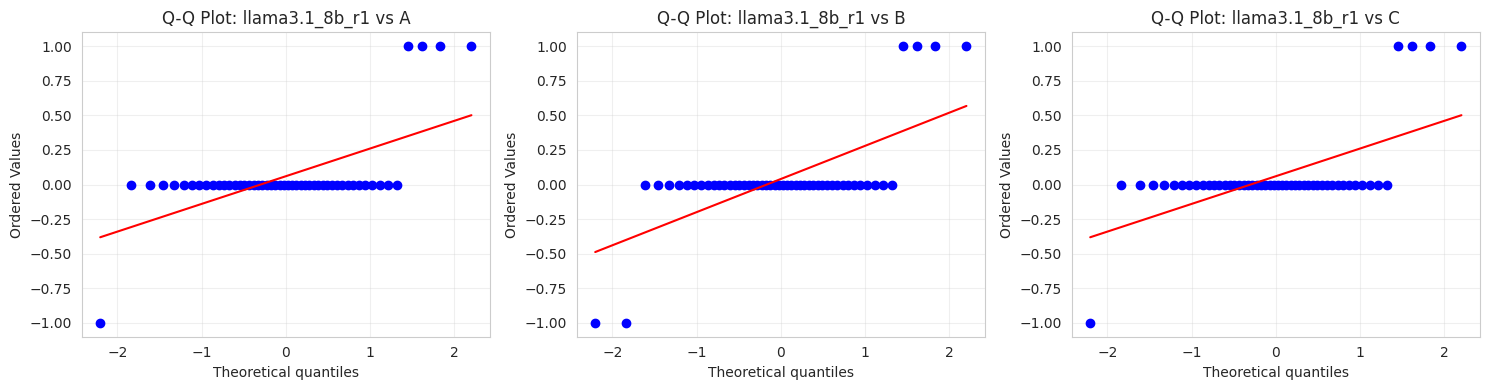


Summary of differences (d = W^h - W^f) for each human:

vs A:
  Mean: 0.0600
  Std: 0.3136
  Min: -1.0, Max: 1.0
  Unique values: 3 (possible: (-1, 0, 1))

vs B:
  Mean: 0.0400
  Std: 0.3476
  Min: -1.0, Max: 1.0
  Unique values: 3 (possible: (-1, 0, 1))

vs C:
  Mean: 0.0600
  Std: 0.3136
  Min: -1.0, Max: 1.0
  Unique values: 3 (possible: (-1, 0, 1))


In [12]:
# Visualize normality of differences for the test case
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (human, res) in enumerate(test_results.items()):
    d = np.array(res['W_h']) - np.array(res['W_f'])
    
    # Q-Q plot
    stats.probplot(d, dist="norm", plot=axes[idx])
    axes[idx].set_title(f'Q-Q Plot: {test_llm} vs {human}')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics for differences
print("\nSummary of differences (d = W^h - W^f) for each human:")
for human, res in test_results.items():
    d = np.array(res['W_h']) - np.array(res['W_f'])
    print(f"\nvs {human}:")
    print(f"  Mean: {np.mean(d):.4f}")
    print(f"  Std: {np.std(d, ddof=1):.4f}")
    print(f"  Min: {np.min(d):.1f}, Max: {np.max(d):.1f}")
    print(f"  Unique values: {len(np.unique(d))} (possible: {-1, 0, 1})")


## 5. Individual Category Analysis <a id="5-individual"></a>

We now perform the complete Alt-Test for each commit category (BFC, BPC, PRC, NFC) individually.

In [13]:
def analyze_llms_for_category(category_df, llm_names, human_annotators, epsilon=0.0, alpha=0.05):
    """
    Perform Alt-Test for all LLMs on a single category.
    
    Args:
        category_df: DataFrame with annotations for the category
        llm_names: List of LLM names to test
        human_annotators: List of human annotator names
        epsilon: Cost-benefit hyperparameter (default: 0.0)
        alpha: Significance level (default: 0.05)
    
    Returns:
        DataFrame with results for all LLMs
    """
    results = []
    
    for llm_name in llm_names:
        # Compute advantage probabilities
        adv_probs = compute_advantage_probabilities(
            category_df, llm_name, human_annotators
        )
        
        # Perform alt-test
        alt_test = perform_alt_test(adv_probs, epsilon, alpha)
        
        # Store results
        result_row = {
            'LLM': llm_name,
            'Winning_Rate': alt_test['winning_rate'],
            'Avg_Advantage_Prob': alt_test['avg_advantage_prob'],
            'Can_Replace': alt_test['can_replace']
        }
        
        # Add per-human results
        for human in human_annotators:
            res = alt_test['test_results'][human]
            result_row[f'rho_f_vs_{human}'] = res['rho_f']
            result_row[f'p_value_vs_{human}'] = res['p_value']
            result_row[f'rejected_vs_{human}'] = res['rejected']
        
        results.append(result_row)
    
    return pd.DataFrame(results)

In [14]:
# Analyze all categories
category_results = {}
llm_names = list(llm_data.keys())

for category in categories:
    results_df = analyze_llms_for_category(
        unified_data[category],
        llm_names,
        human_annotators,
        epsilon=EPSILON_PRIMARY,
        alpha=ALPHA
    )
    category_results[category] = results_df

In [15]:
# Display results for each category with detailed p-values
for category in categories:
    print(f"\n{'='*100}")
    print(f"{category.upper()} CATEGORY RESULTS")
    print(f"{'='*100}")
    
    df = category_results[category].sort_values('Avg_Advantage_Prob', ascending=False)
    
    # Display summary columns
    display_cols = ['LLM', 'Winning_Rate', 'Avg_Advantage_Prob', 'Can_Replace']
    display(df[display_cols])
    
    # Detailed p-values table
    print(f"\n{'-'*100}")
    print("DETAILED P-VALUES AND REJECTION STATUS (after Benjamini-Yekutieli correction)")
    print(f"{'-'*100}")
    print(f"{'LLM':<30} {'vs A':<20} {'vs B':<20} {'vs C':<20}")
    print(f"{'-'*100}")
    
    for idx, row in df.iterrows():
        p_a = row['p_value_vs_A']
        p_b = row['p_value_vs_B']
        p_c = row['p_value_vs_C']
        
        rej_a = '✓' if row['rejected_vs_A'] else '✗'
        rej_b = '✓' if row['rejected_vs_B'] else '✗'
        rej_c = '✓' if row['rejected_vs_C'] else '✗'
        
        print(f"{row['LLM']:<30} {rej_a} p={p_a:.6f}    {rej_b} p={p_b:.6f}    {rej_c} p={p_c:.6f}")
    
    print(f"{'-'*100}")
    print("Legend: ✓ = H₀ rejected (LLM wins), ✗ = H₀ not rejected")
    
    # Advantage probabilities table
    print(f"\n{'-'*100}")
    print("ADVANTAGE PROBABILITIES (ρ^f): Probability that LLM ≥ Human")
    print(f"{'-'*100}")
    print(f"{'LLM':<30} {'vs A':<15} {'vs B':<15} {'vs C':<15} {'Average':<15}")
    print(f"{'-'*100}")
    
    for idx, row in df.iterrows():
        rho_a = row['rho_f_vs_A']
        rho_b = row['rho_f_vs_B']
        rho_c = row['rho_f_vs_C']
        avg = row['Avg_Advantage_Prob']
        
        print(f"{row['LLM']:<30} {rho_a:.4f}          {rho_b:.4f}          {rho_c:.4f}          {avg:.4f}")
    
    print(f"{'-'*100}")
    
    # Summary statistics
    n_can_replace = df['Can_Replace'].sum()
    print(f"\n📊 SUMMARY: {n_can_replace}/{len(df)} LLMs can replace human annotators (ω ≥ 0.5)")
    print(f"🏆 Best LLM: {df.iloc[0]['LLM']} (ρ = {df.iloc[0]['Avg_Advantage_Prob']:.4f}, ω = {df.iloc[0]['Winning_Rate']:.3f})")
    
    # Show which humans were beaten by best LLM
    best = df.iloc[0]
    beaten = []
    if best['rejected_vs_A']:
        beaten.append('A')
    if best['rejected_vs_B']:
        beaten.append('B')
    if best['rejected_vs_C']:
        beaten.append('C')
    
    if beaten:
        print(f"   Beats humans: {', '.join(beaten)}")
    else:
        print(f"   Does not beat any human (ω < 0.5)")


BFC CATEGORY RESULTS


,LLM,Winning_Rate,Avg_Advantage_Prob,Can_Replace
4,llama3.1_8b_r1,1.0,0.92,True
3,gpt-oss_20b_r1,1.0,0.90,True
2,gemma3_12b_r1,1.0,0.88,True
6,qwen3-coder_30b_r1,1.0,0.88,True
5,mistral_7b_r1,1.0,0.86,True
0,codellama_13b_r1,1.0,0.84,True
1,deepseek-r1_14b_r1,1.0,0.82,True



----------------------------------------------------------------------------------------------------
DETAILED P-VALUES AND REJECTION STATUS (after Benjamini-Yekutieli correction)
----------------------------------------------------------------------------------------------------
LLM                            vs A                 vs B                 vs C                
----------------------------------------------------------------------------------------------------
llama3.1_8b_r1                 ✓ p=0.000000    ✓ p=0.000000    ✓ p=0.000000
gpt-oss_20b_r1                 ✓ p=0.000000    ✓ p=0.000000    ✓ p=0.000000
gemma3_12b_r1                  ✓ p=0.000000    ✓ p=0.000000    ✓ p=0.000000
qwen3-coder_30b_r1             ✓ p=0.000000    ✓ p=0.000000    ✓ p=0.000000
mistral_7b_r1                  ✓ p=0.000000    ✓ p=0.000000    ✓ p=0.000000
codellama_13b_r1               ✓ p=0.000001    ✓ p=0.000001    ✓ p=0.000001
deepseek-r1_14b_r1             ✓ p=0.000003    ✓ p=0.000003    ✓ p=0

,LLM,Winning_Rate,Avg_Advantage_Prob,Can_Replace
1,deepseek-r1_14b_r1,0.666667,0.660000,True
3,gpt-oss_20b_r1,0.000000,0.586667,False
6,qwen3-coder_30b_r1,0.000000,0.573333,False
5,mistral_7b_r1,0.000000,0.533333,False
0,codellama_13b_r1,0.000000,0.486667,False
4,llama3.1_8b_r1,0.000000,0.466667,False
2,gemma3_12b_r1,0.000000,0.460000,False



----------------------------------------------------------------------------------------------------
DETAILED P-VALUES AND REJECTION STATUS (after Benjamini-Yekutieli correction)
----------------------------------------------------------------------------------------------------
LLM                            vs A                 vs B                 vs C                
----------------------------------------------------------------------------------------------------
deepseek-r1_14b_r1             ✓ p=0.016420    ✓ p=0.007673    ✗ p=0.032454
gpt-oss_20b_r1                 ✗ p=0.101319    ✗ p=0.161118    ✗ p=0.161118
qwen3-coder_30b_r1             ✗ p=0.161118    ✗ p=0.239944    ✗ p=0.161118
mistral_7b_r1                  ✗ p=0.335906    ✗ p=0.335906    ✗ p=0.443862
codellama_13b_r1               ✗ p=0.556138    ✗ p=0.664094    ✗ p=0.664094
llama3.1_8b_r1                 ✗ p=0.664094    ✗ p=0.760056    ✗ p=0.760056
gemma3_12b_r1                  ✗ p=0.760056    ✗ p=0.760056    ✗ p=0

,LLM,Winning_Rate,Avg_Advantage_Prob,Can_Replace
3,gpt-oss_20b_r1,1.0,0.846667,True
1,deepseek-r1_14b_r1,0.0,0.626667,False
6,qwen3-coder_30b_r1,0.0,0.540000,False
0,codellama_13b_r1,0.0,0.460000,False
2,gemma3_12b_r1,0.0,0.440000,False
5,mistral_7b_r1,0.0,0.380000,False
4,llama3.1_8b_r1,0.0,0.340000,False



----------------------------------------------------------------------------------------------------
DETAILED P-VALUES AND REJECTION STATUS (after Benjamini-Yekutieli correction)
----------------------------------------------------------------------------------------------------
LLM                            vs A                 vs B                 vs C                
----------------------------------------------------------------------------------------------------
gpt-oss_20b_r1                 ✓ p=0.000001    ✓ p=0.000000    ✓ p=0.000001
deepseek-r1_14b_r1             ✗ p=0.059460    ✗ p=0.032454    ✗ p=0.059460
qwen3-coder_30b_r1             ✗ p=0.335906    ✗ p=0.335906    ✗ p=0.335906
codellama_13b_r1               ✗ p=0.760056    ✗ p=0.760056    ✗ p=0.760056
gemma3_12b_r1                  ✗ p=0.838882    ✗ p=0.838882    ✗ p=0.838882
mistral_7b_r1                  ✗ p=0.967546    ✗ p=0.967546    ✗ p=0.967546
llama3.1_8b_r1                 ✗ p=0.992327    ✗ p=0.992327    ✗ p=0

,LLM,Winning_Rate,Avg_Advantage_Prob,Can_Replace
4,llama3.1_8b_r1,1.0,0.980000,True
1,deepseek-r1_14b_r1,1.0,0.960000,True
2,gemma3_12b_r1,1.0,0.906667,True
6,qwen3-coder_30b_r1,1.0,0.900000,True
3,gpt-oss_20b_r1,1.0,0.900000,True
0,codellama_13b_r1,1.0,0.840000,True
5,mistral_7b_r1,1.0,0.820000,True



----------------------------------------------------------------------------------------------------
DETAILED P-VALUES AND REJECTION STATUS (after Benjamini-Yekutieli correction)
----------------------------------------------------------------------------------------------------
LLM                            vs A                 vs B                 vs C                
----------------------------------------------------------------------------------------------------
llama3.1_8b_r1                 ✓ p=0.000000    ✓ p=0.000000    ✓ p=0.000000
deepseek-r1_14b_r1             ✓ p=0.000000    ✓ p=0.000000    ✓ p=0.000000
gemma3_12b_r1                  ✓ p=0.000000    ✓ p=0.000000    ✓ p=0.000000
qwen3-coder_30b_r1             ✓ p=0.000000    ✓ p=0.000000    ✓ p=0.000000
gpt-oss_20b_r1                 ✓ p=0.000000    ✓ p=0.000000    ✓ p=0.000000
codellama_13b_r1               ✓ p=0.000001    ✓ p=0.000001    ✓ p=0.000001
mistral_7b_r1                  ✓ p=0.000003    ✓ p=0.000003    ✓ p=0

## 6. Combined Category Analysis <a id="6-combined"></a>

We now analyze all four categories together, treating the annotation as a 4-dimensional vector.
We use RMSE across all dimensions simultaneously.

In [16]:
def compute_multivariate_rmse_score(f_annotations, other_annotations):
    """
    Compute negative RMSE for multivariate annotations (all 4 categories).
    
    Args:
        f_annotations: 1D array with 4 values [bfc, bpc, prc, nfc]
        other_annotations: 2D array (n_annotators × 4)
    
    Returns:
        Negative RMSE score
    """
    # Compute squared differences across all dimensions
    squared_diffs = np.sum((f_annotations - other_annotations) ** 2, axis=1)
    return -np.sqrt(np.mean(squared_diffs))

def compute_combined_advantage_probabilities(unified_data, llm_name, human_annotators, categories):
    """
    Compute advantage probabilities considering all categories together.
    """
    # Create combined dataset with all categories
    # We need commits that have complete annotations across all categories
    combined_df = unified_data[categories[0]][['hash']].copy()
    
    for cat in categories:
        cat_df = unified_data[cat]
        # Add columns with category suffix
        for col in human_annotators + [llm_name]:
            combined_df = combined_df.merge(
                cat_df[['hash', col]].rename(columns={col: f'{col}_{cat}'}),
                on='hash',
                how='inner'
            )
    
    results = {}
    
    for excluded_human in human_annotators:
        remaining_humans = [h for h in human_annotators if h != excluded_human]
        
        W_f_list = []
        W_h_list = []
        
        for idx, row in combined_df.iterrows():
            # Get multivariate annotations (4D vectors)
            llm_annotation = np.array([row[f'{llm_name}_{cat}'] for cat in categories])
            excluded_annotation = np.array([row[f'{excluded_human}_{cat}'] for cat in categories])
            remaining_annotations = np.array([
                [row[f'{h}_{cat}'] for cat in categories]
                for h in remaining_humans
            ])
            
            # Compute scores
            S_llm = compute_multivariate_rmse_score(llm_annotation, remaining_annotations)
            S_human = compute_multivariate_rmse_score(excluded_annotation, remaining_annotations)
            
            # Indicators
            W_f = 1 if S_llm >= S_human else 0
            W_h = 1 if S_human >= S_llm else 0
            
            W_f_list.append(W_f)
            W_h_list.append(W_h)
        
        results[excluded_human] = {
            'rho_f': np.mean(W_f_list),
            'rho_h': np.mean(W_h_list),
            'W_f': W_f_list,
            'W_h': W_h_list,
            'n_instances': len(W_f_list)
        }
    
    return results

In [17]:
# Perform combined analysis for all LLMs
print(f"Performing combined category analysis (ε={EPSILON_PRIMARY})...\n")
combined_results = []

for llm_name in llm_names:
    
    # Compute advantage probabilities
    adv_probs = compute_combined_advantage_probabilities(
        unified_data, llm_name, human_annotators, categories
    )
    
    # Perform alt-test
    alt_test = perform_alt_test(adv_probs, epsilon=EPSILON_PRIMARY, alpha=ALPHA)
    
    # Store results
    result_row = {
        'LLM': llm_name,
        'Winning_Rate': alt_test['winning_rate'],
        'Avg_Advantage_Prob': alt_test['avg_advantage_prob'],
        'Can_Replace': alt_test['can_replace']
    }
    
    for human in human_annotators:
        res = alt_test['test_results'][human]
        result_row[f'rho_f_vs_{human}'] = res['rho_f']
        result_row[f'p_value_vs_{human}'] = res['p_value']
        result_row[f'rejected_vs_{human}'] = res['rejected']
    
    combined_results.append(result_row)

combined_results_df = pd.DataFrame(combined_results).sort_values('Avg_Advantage_Prob', ascending=False)

Performing combined category analysis (ε=0.15)...



In [18]:
# Display combined results with detailed information
print("\n" + "="*100)
print("COMBINED CATEGORY RESULTS (All 4 categories together)")
print("="*100 + "\n")

display_cols = ['LLM', 'Winning_Rate', 'Avg_Advantage_Prob', 'Can_Replace']
display(combined_results_df[display_cols])

# Detailed p-values table
print(f"\n{'-'*100}")
print("DETAILED P-VALUES AND REJECTION STATUS (after Benjamini-Yekutieli correction)")
print(f"{'-'*100}")
print(f"{'LLM':<30} {'vs A':<20} {'vs B':<20} {'vs C':<20}")
print(f"{'-'*100}")

for idx, row in combined_results_df.iterrows():
    p_a = row['p_value_vs_A']
    p_b = row['p_value_vs_B']
    p_c = row['p_value_vs_C']
    
    rej_a = '✓' if row['rejected_vs_A'] else '✗'
    rej_b = '✓' if row['rejected_vs_B'] else '✗'
    rej_c = '✓' if row['rejected_vs_C'] else '✗'
    
    print(f"{row['LLM']:<30} {rej_a} p={p_a:.6f}    {rej_b} p={p_b:.6f}    {rej_c} p={p_c:.6f}")

print(f"{'-'*100}")
print("Legend: ✓ = H₀ rejected (LLM wins), ✗ = H₀ not rejected")

# Advantage probabilities table
print(f"\n{'-'*100}")
print("ADVANTAGE PROBABILITIES (ρ^f): Probability that LLM ≥ Human")
print(f"{'-'*100}")
print(f"{'LLM':<30} {'vs A':<15} {'vs B':<15} {'vs C':<15} {'Average':<15}")
print(f"{'-'*100}")

for idx, row in combined_results_df.iterrows():
    rho_a = row['rho_f_vs_A']
    rho_b = row['rho_f_vs_B']
    rho_c = row['rho_f_vs_C']
    avg = row['Avg_Advantage_Prob']
    
    print(f"{row['LLM']:<30} {rho_a:.4f}          {rho_b:.4f}          {rho_c:.4f}          {avg:.4f}")

print(f"{'-'*100}")

n_can_replace = combined_results_df['Can_Replace'].sum()
print(f"\n📊 SUMMARY: {n_can_replace}/{len(combined_results_df)} LLMs can replace human annotators (ω ≥ 0.5)")
print(f"🏆 Best LLM: {combined_results_df.iloc[0]['LLM']} (ρ = {combined_results_df.iloc[0]['Avg_Advantage_Prob']:.4f}, ω = {combined_results_df.iloc[0]['Winning_Rate']:.3f})")

# Show which humans were beaten by best LLM
best = combined_results_df.iloc[0]
beaten = []
if best['rejected_vs_A']:
    beaten.append('A')
if best['rejected_vs_B']:
    beaten.append('B')
if best['rejected_vs_C']:
    beaten.append('C')

if beaten:
    print(f"   Beats humans: {', '.join(beaten)}")
else:
    print(f"   Does not beat any human (ω < 0.5)")

# Statistical significance summary
print(f"\n{'-'*100}")
print("STATISTICAL SIGNIFICANCE SUMMARY")
print(f"{'-'*100}")
print(f"Epsilon (ε):             {EPSILON_PRIMARY}")
print(f"Significance level (α):  {ALPHA}")
print(f"Multiple testing:        Benjamini-Yekutieli FDR correction")
print(f"Statistical test:        Wilcoxon signed-rank (non-parametric, for non-normal differences)")
print(f"\nInterpretation of results:")
print(f"  - ✓ (rejected): p < {ALPHA} after BY correction → LLM significantly better than human")
print(f"  - ✗ (not rejected): p ≥ {ALPHA} → Insufficient evidence that LLM is better")
print(f"  - Winning Rate (ω): Proportion of humans beaten (need ω ≥ 0.5 to replace)")
print(f"{'-'*100}")


COMBINED CATEGORY RESULTS (All 4 categories together)



,LLM,Winning_Rate,Avg_Advantage_Prob,Can_Replace
3,gpt-oss_20b_r1,0.0,0.486667,False
6,qwen3-coder_30b_r1,0.0,0.440000,False
1,deepseek-r1_14b_r1,0.0,0.406667,False
2,gemma3_12b_r1,0.0,0.320000,False
4,llama3.1_8b_r1,0.0,0.280000,False
5,mistral_7b_r1,0.0,0.266667,False
0,codellama_13b_r1,0.0,0.220000,False



----------------------------------------------------------------------------------------------------
DETAILED P-VALUES AND REJECTION STATUS (after Benjamini-Yekutieli correction)
----------------------------------------------------------------------------------------------------
LLM                            vs A                 vs B                 vs C                
----------------------------------------------------------------------------------------------------
gpt-oss_20b_r1                 ✗ p=0.443862    ✗ p=0.664094    ✗ p=0.760056
qwen3-coder_30b_r1             ✗ p=0.664094    ✗ p=0.838882    ✗ p=0.940540
deepseek-r1_14b_r1             ✗ p=0.898681    ✗ p=0.838882    ✗ p=0.983580
gemma3_12b_r1                  ✗ p=0.996700    ✗ p=0.992327    ✗ p=0.998699
llama3.1_8b_r1                 ✗ p=0.996700    ✗ p=0.999532    ✗ p=0.999955
mistral_7b_r1                  ✗ p=0.999847    ✗ p=0.998699    ✗ p=0.999955
codellama_13b_r1               ✗ p=0.999847    ✗ p=0.999955    ✗ p=1

## 7. Visualizations <a id="7-visualizations"></a>

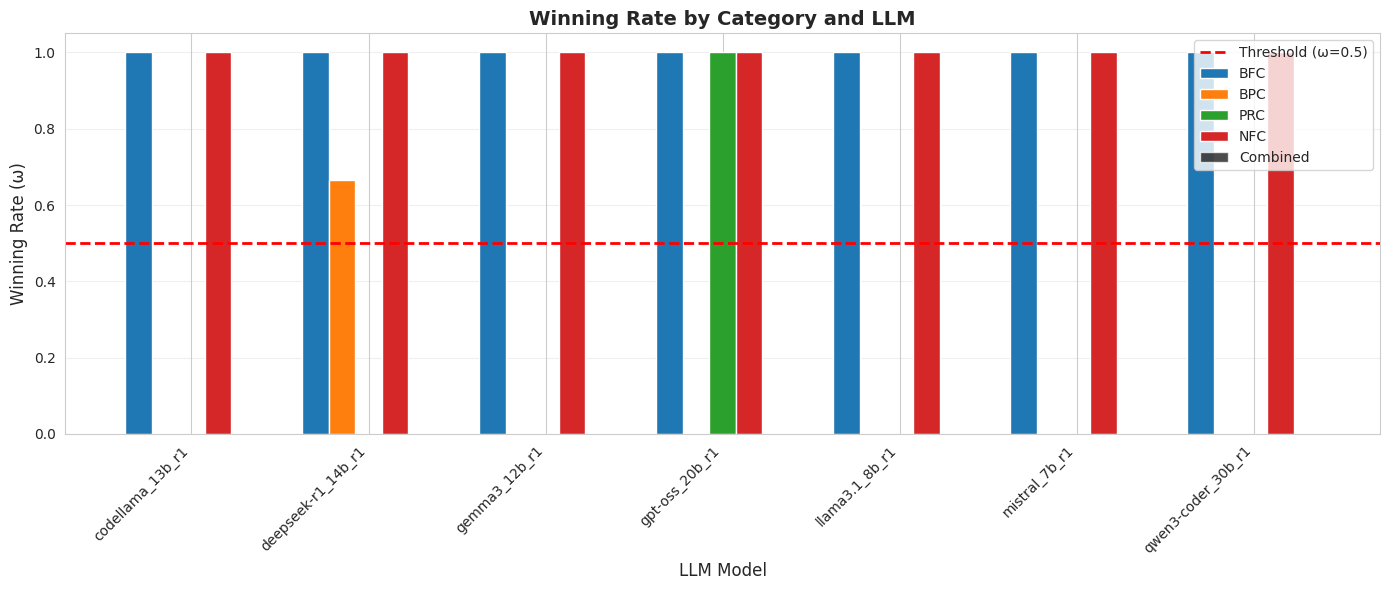

In [19]:
# 1. Winning Rate comparison across categories
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(llm_names))
width = 0.15

for i, category in enumerate(categories):
    df = category_results[category].set_index('LLM').loc[llm_names]
    ax.bar(x + i*width, df['Winning_Rate'], width, label=category.upper())

# Add combined results
combined_df = combined_results_df.set_index('LLM').loc[llm_names]
ax.bar(x + 4*width, combined_df['Winning_Rate'], width, label='Combined', color='black', alpha=0.7)

ax.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (ω=0.5)')
ax.set_xlabel('LLM Model', fontsize=12)
ax.set_ylabel('Winning Rate (ω)', fontsize=12)
ax.set_title('Winning Rate by Category and LLM', fontsize=14, fontweight='bold')
ax.set_xticks(x + 2*width)
ax.set_xticklabels(llm_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

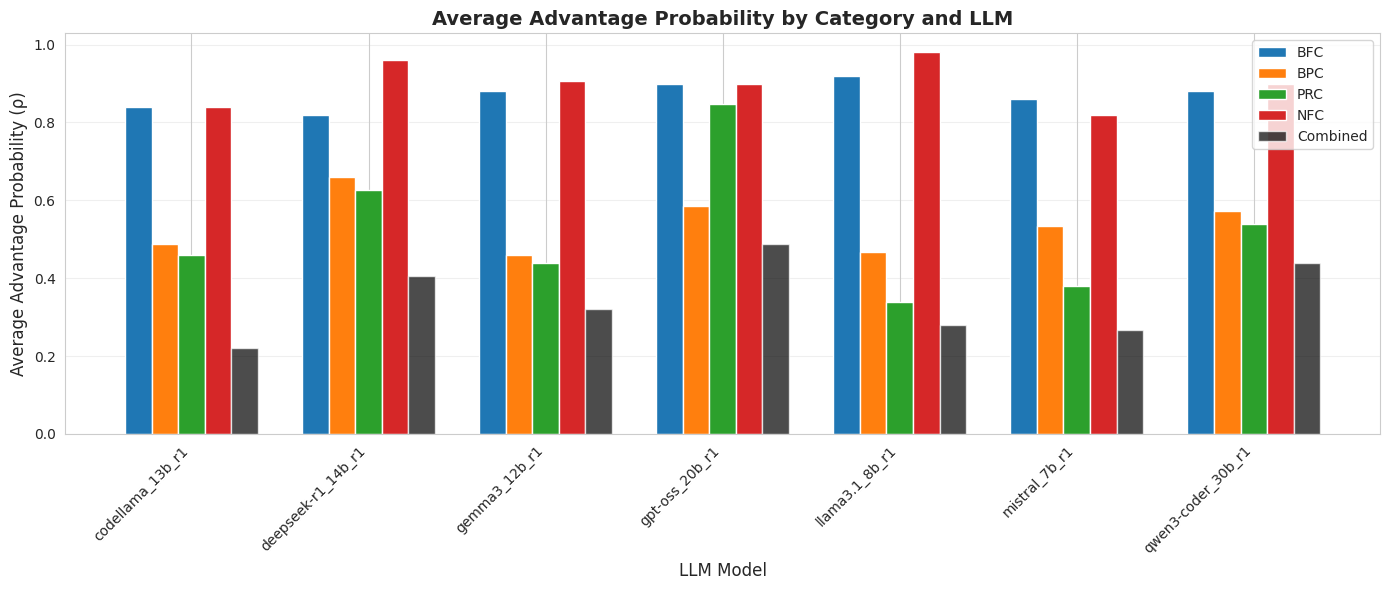

In [20]:
# 2. Average Advantage Probability (ρ) comparison
fig, ax = plt.subplots(figsize=(14, 6))

for i, category in enumerate(categories):
    df = category_results[category].set_index('LLM').loc[llm_names]
    ax.bar(x + i*width, df['Avg_Advantage_Prob'], width, label=category.upper())

combined_df = combined_results_df.set_index('LLM').loc[llm_names]
ax.bar(x + 4*width, combined_df['Avg_Advantage_Prob'], width, label='Combined', color='black', alpha=0.7)

ax.set_xlabel('LLM Model', fontsize=12)
ax.set_ylabel('Average Advantage Probability (ρ)', fontsize=12)
ax.set_title('Average Advantage Probability by Category and LLM', fontsize=14, fontweight='bold')
ax.set_xticks(x + 2*width)
ax.set_xticklabels(llm_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

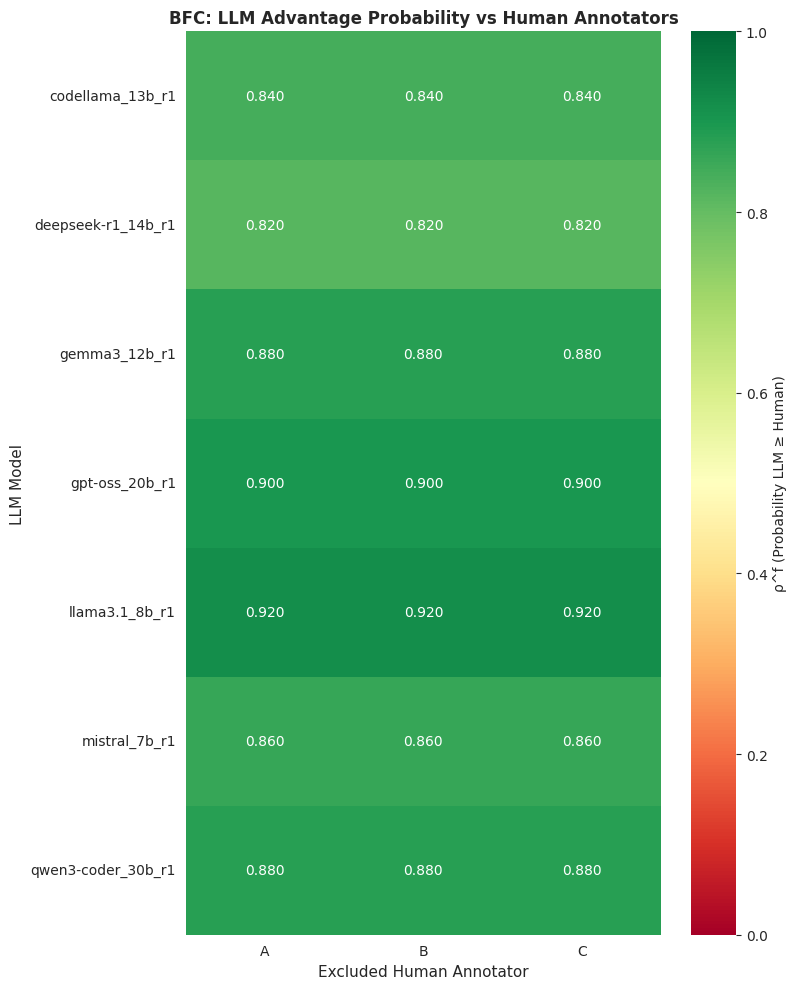

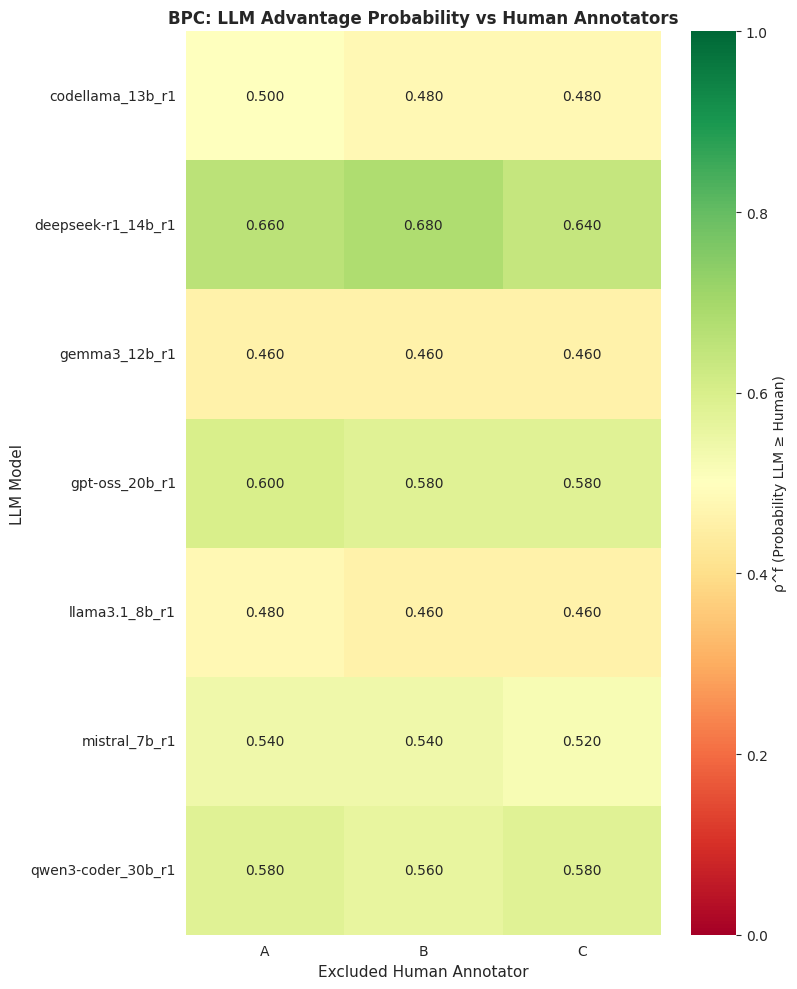

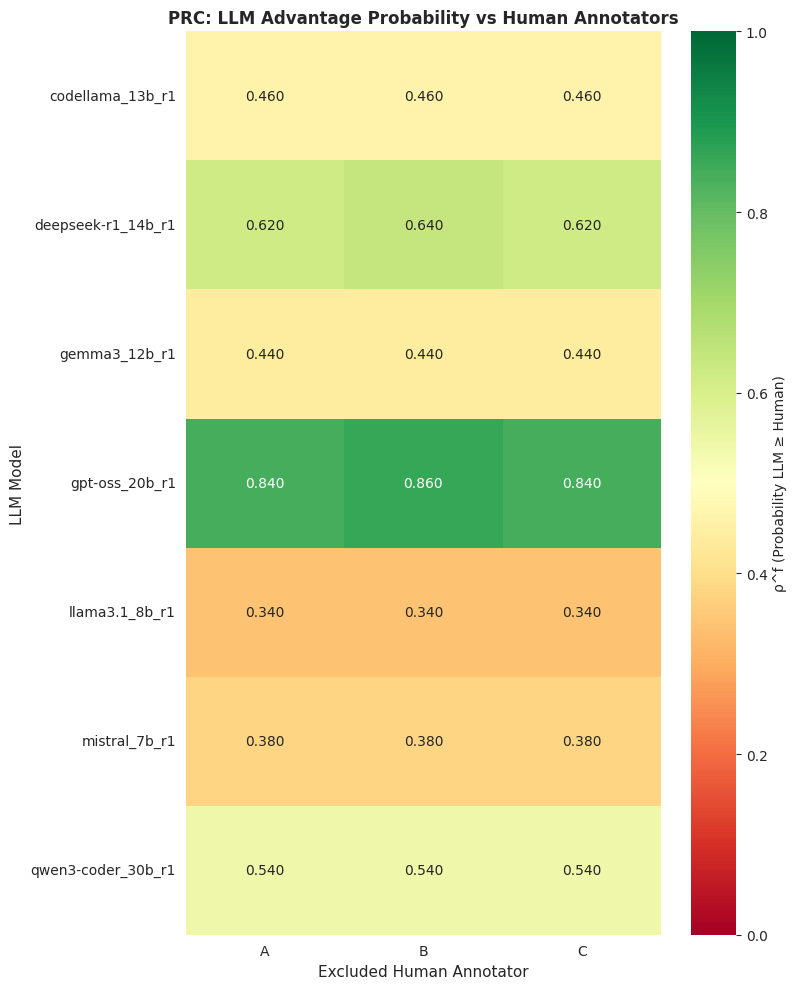

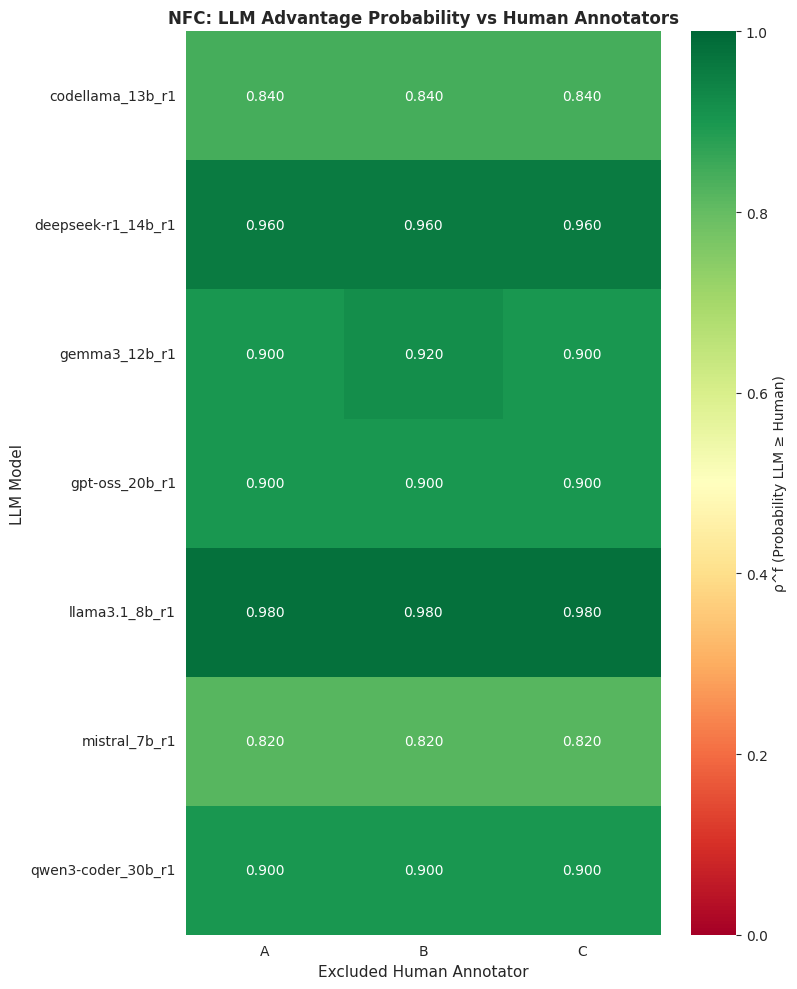

In [21]:
# 3. Heatmap of ρ^f (LLM advantage probability) vs human annotators
for category in categories:
    fig, ax = plt.subplots(figsize=(8, 10))
    
    df = category_results[category]
    
    # Create matrix: rows=LLMs, cols=human annotators
    matrix = np.zeros((len(llm_names), len(human_annotators)))
    for i, llm in enumerate(llm_names):
        for j, human in enumerate(human_annotators):
            matrix[i, j] = df[df['LLM'] == llm][f'rho_f_vs_{human}'].values[0]
    
    sns.heatmap(matrix, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
                xticklabels=human_annotators, yticklabels=llm_names,
                cbar_kws={'label': 'ρ^f (Probability LLM ≥ Human)'}, ax=ax)
    
    ax.set_title(f'{category.upper()}: LLM Advantage Probability vs Human Annotators', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Excluded Human Annotator', fontsize=11)
    ax.set_ylabel('LLM Model', fontsize=11)
    plt.tight_layout()
    plt.show()

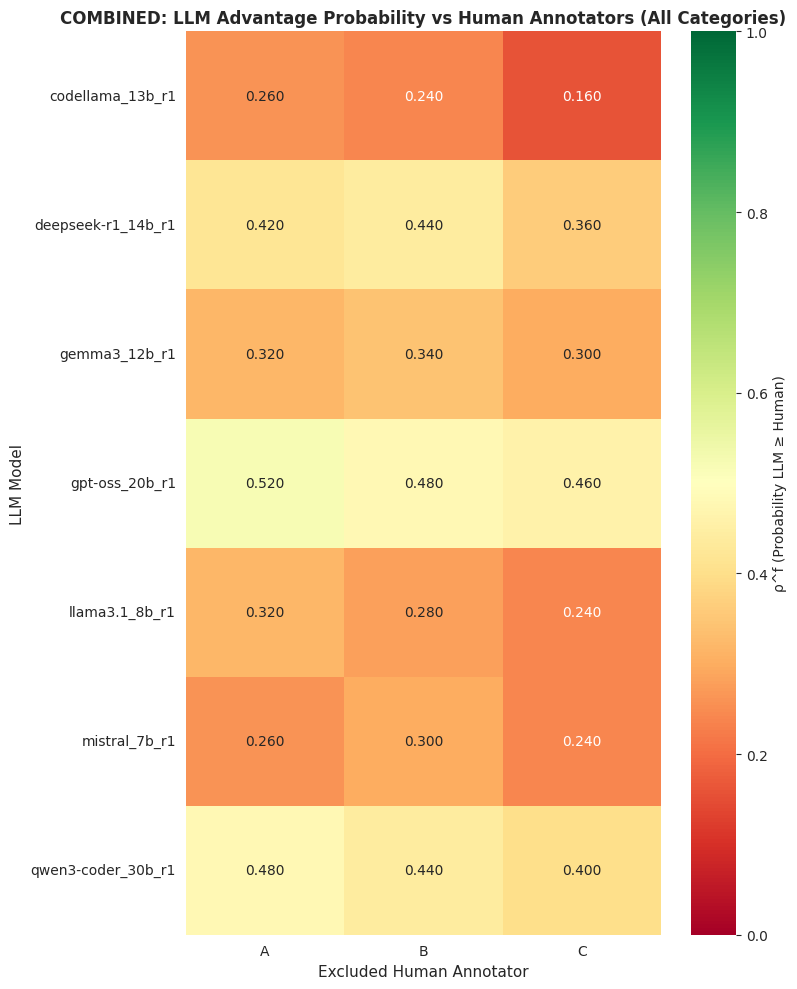

In [22]:
# 4. Combined category heatmap
fig, ax = plt.subplots(figsize=(8, 10))

matrix = np.zeros((len(llm_names), len(human_annotators)))
for i, llm in enumerate(llm_names):
    for j, human in enumerate(human_annotators):
        matrix[i, j] = combined_results_df[combined_results_df['LLM'] == llm][f'rho_f_vs_{human}'].values[0]

sns.heatmap(matrix, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
            xticklabels=human_annotators, yticklabels=llm_names,
            cbar_kws={'label': 'ρ^f (Probability LLM ≥ Human)'}, ax=ax)

ax.set_title('COMBINED: LLM Advantage Probability vs Human Annotators (All Categories)', 
             fontsize=12, fontweight='bold')
ax.set_xlabel('Excluded Human Annotator', fontsize=11)
ax.set_ylabel('LLM Model', fontsize=11)
plt.tight_layout()
plt.show()

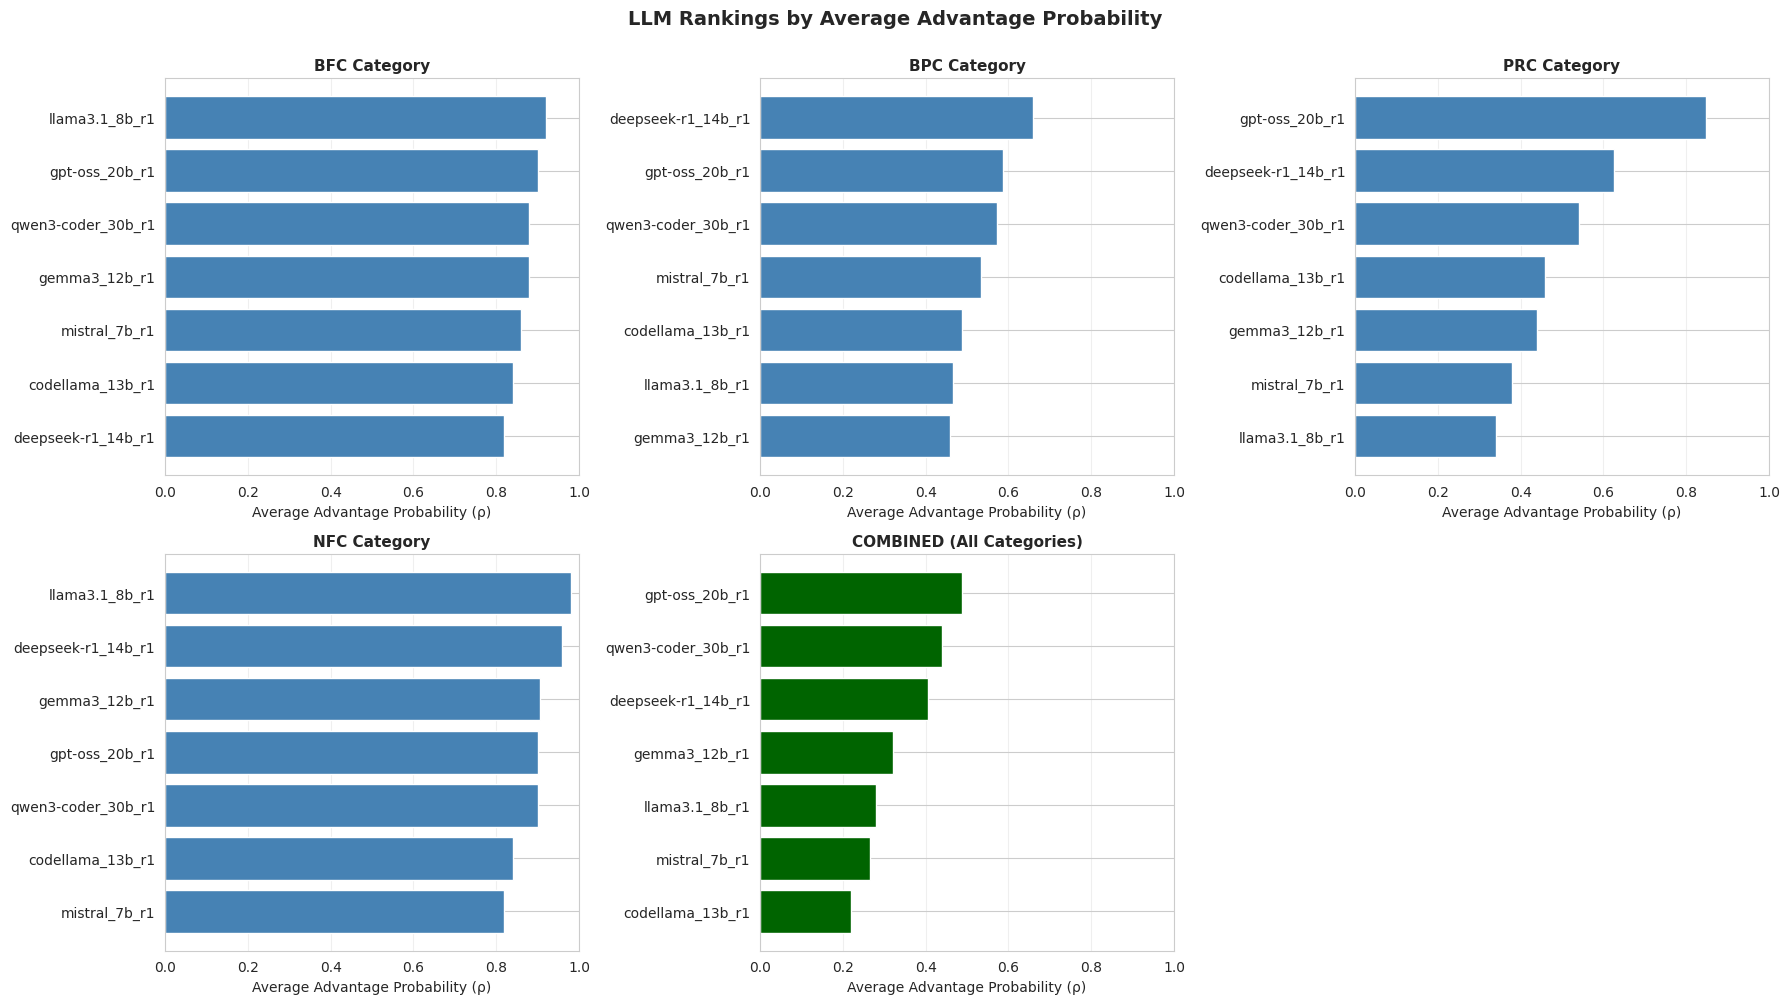

In [23]:
# 5. LLM Ranking by Average Advantage Probability
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Individual categories
for i, category in enumerate(categories):
    df = category_results[category].sort_values('Avg_Advantage_Prob', ascending=True)
    axes[i].barh(df['LLM'], df['Avg_Advantage_Prob'], color='steelblue')
    axes[i].set_xlabel('Average Advantage Probability (ρ)', fontsize=10)
    axes[i].set_title(f'{category.upper()} Category', fontsize=11, fontweight='bold')
    axes[i].grid(axis='x', alpha=0.3)
    axes[i].set_xlim([0, 1])

# Combined
df_combined = combined_results_df.sort_values('Avg_Advantage_Prob', ascending=True)
axes[4].barh(df_combined['LLM'], df_combined['Avg_Advantage_Prob'], color='darkgreen')
axes[4].set_xlabel('Average Advantage Probability (ρ)', fontsize=10)
axes[4].set_title('COMBINED (All Categories)', fontsize=11, fontweight='bold')
axes[4].grid(axis='x', alpha=0.3)
axes[4].set_xlim([0, 1])

# Hide the last subplot
axes[5].axis('off')

plt.suptitle('LLM Rankings by Average Advantage Probability', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 8. Epsilon Sensitivity Analysis <a id="8-sensitivity"></a>

We now test how the results change with different epsilon values to validate our choice of ε=0.15.

In [24]:
# Perform sensitivity analysis with different epsilon values BY CATEGORY
print("Performing epsilon sensitivity analysis by category...\n")

sensitivity_results = []

for category in categories:
    print(f"\n{'='*60}")
    print(f"Category: {category.upper()}")
    print(f"{'='*60}")
    
    for eps in EPSILON_SENSITIVITY:
        print(f"  Testing ε = {eps}")
        
        # Test on THIS category
        for llm_name in llm_names:
            adv_probs = compute_advantage_probabilities(
                unified_data[category], llm_name, human_annotators
            )
            alt_test = perform_alt_test(adv_probs, epsilon=eps, alpha=ALPHA)
            
            sensitivity_results.append({
                'category': category,
                'epsilon': eps,
                'LLM': llm_name,
                'Winning_Rate': alt_test['winning_rate'],
                'Avg_Advantage_Prob': alt_test['avg_advantage_prob'],
                'Can_Replace': alt_test['can_replace']
            })
        
        n_can_replace = sum(
            r['Can_Replace'] for r in sensitivity_results 
            if r['epsilon']==eps and r['category']==category
        )
        print(f"    {category.upper()}: {n_can_replace}/{len(llm_names)} LLMs can replace")

sensitivity_df = pd.DataFrame(sensitivity_results)

Performing epsilon sensitivity analysis by category...


Category: BFC
  Testing ε = 0.0
    BFC: 0/7 LLMs can replace
  Testing ε = 0.05
    BFC: 7/7 LLMs can replace
  Testing ε = 0.1
    BFC: 7/7 LLMs can replace
  Testing ε = 0.15
    BFC: 7/7 LLMs can replace
  Testing ε = 0.2
    BFC: 7/7 LLMs can replace

Category: BPC
  Testing ε = 0.0
    BPC: 0/7 LLMs can replace
  Testing ε = 0.05
    BPC: 1/7 LLMs can replace
  Testing ε = 0.1
    BPC: 1/7 LLMs can replace
  Testing ε = 0.15
    BPC: 1/7 LLMs can replace
  Testing ε = 0.2
    BPC: 1/7 LLMs can replace

Category: PRC
  Testing ε = 0.0
    PRC: 0/7 LLMs can replace
  Testing ε = 0.05
    PRC: 1/7 LLMs can replace
  Testing ε = 0.1
    PRC: 1/7 LLMs can replace
  Testing ε = 0.15
    PRC: 1/7 LLMs can replace
  Testing ε = 0.2
    PRC: 1/7 LLMs can replace

Category: NFC
  Testing ε = 0.0
    NFC: 0/7 LLMs can replace
  Testing ε = 0.05
    NFC: 7/7 LLMs can replace
  Testing ε = 0.1
    NFC: 7/7 LLMs can replace
  Testing ε =

In [25]:
# Display sensitivity results table BY CATEGORY
print("\n" + "="*80)
print("EPSILON SENSITIVITY ANALYSIS RESULTS BY CATEGORY")
print("="*80)

for category in categories:
    print(f"\n{'█'*80}")
    print(f"CATEGORY: {category.upper()}")
    print(f"{'█'*80}")
    
    for eps in EPSILON_SENSITIVITY:
        print(f"\n{'─'*80}")
        print(f"ε = {eps}")
        print(f"{'─'*80}")
        
        eps_results = sensitivity_df[
            (sensitivity_df['epsilon'] == eps) & 
            (sensitivity_df['category'] == category)
        ].sort_values('Avg_Advantage_Prob', ascending=False)
        
        for idx, row in eps_results.iterrows():
            status = "✓ CAN" if row['Can_Replace'] else "✗ CANNOT"
            print(f"{status:12s} | {row['LLM']:25s} | ω={row['Winning_Rate']:.3f} | ρ={row['Avg_Advantage_Prob']:.3f}")
        
        n_pass = eps_results['Can_Replace'].sum()
        print(f"\nSummary: {n_pass}/{len(llm_names)} LLMs can replace humans in {category.upper()} with ε={eps}")

print("\n" + "="*80)


EPSILON SENSITIVITY ANALYSIS RESULTS BY CATEGORY

████████████████████████████████████████████████████████████████████████████████
CATEGORY: BFC
████████████████████████████████████████████████████████████████████████████████

────────────────────────────────────────────────────────────────────────────────
ε = 0.0
────────────────────────────────────────────────────────────────────────────────
✗ CANNOT     | llama3.1_8b_r1            | ω=0.000 | ρ=0.920
✗ CANNOT     | gpt-oss_20b_r1            | ω=0.000 | ρ=0.900
✗ CANNOT     | gemma3_12b_r1             | ω=0.000 | ρ=0.880
✗ CANNOT     | qwen3-coder_30b_r1        | ω=0.000 | ρ=0.880
✗ CANNOT     | mistral_7b_r1             | ω=0.000 | ρ=0.860
✗ CANNOT     | codellama_13b_r1          | ω=0.000 | ρ=0.840
✗ CANNOT     | deepseek-r1_14b_r1        | ω=0.000 | ρ=0.820

Summary: 0/7 LLMs can replace humans in BFC with ε=0.0

────────────────────────────────────────────────────────────────────────────────
ε = 0.05
────────────────────────────

## 9. Conclusions and Interpretation <a id="9-conclusions"></a>

In [26]:
# Generate comprehensive summary
print("="*80)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("="*80)
print(f"\n**Epsilon (ε) Used: {EPSILON_PRIMARY}** (skilled annotators)")
print(f"Significance Level (α): {ALPHA}")
print(f"Statistical Test: Sign Test (binomial)")

print("\n1. OVERALL RESULTS (Combined Categories)")
print("-" * 80)
for idx, row in combined_results_df.iterrows():
    status = "✓ CAN REPLACE" if row['Can_Replace'] else "✗ CANNOT REPLACE"
    print(f"{status:20s} | {row['LLM']:25s} | ω={row['Winning_Rate']:.3f} | ρ={row['Avg_Advantage_Prob']:.3f}")

print("\n2. CATEGORY-SPECIFIC RESULTS")
print("-" * 80)
for category in categories:
    print(f"\n{category.upper()} Category:")
    df = category_results[category]
    can_replace = df[df['Can_Replace'] == True]
    print(f"  {len(can_replace)}/{len(df)} LLMs can replace humans")
    if len(can_replace) > 0:
        best = can_replace.sort_values('Avg_Advantage_Prob', ascending=False).iloc[0]
        print(f"  Best: {best['LLM']} (ρ={best['Avg_Advantage_Prob']:.3f})")

print("\n3. BEST PERFORMING LLMs (by Average Advantage Probability)")
print("-" * 80)
top_3 = combined_results_df.head(3)
for rank, (idx, row) in enumerate(top_3.iterrows(), 1):
    print(f"  #{rank}. {row['LLM']:30s} ρ={row['Avg_Advantage_Prob']:.3f}")

print("\n4. STATISTICAL METHODOLOGY")
print("-" * 80)
print("  Sign Test with epsilon-adjusted hypothesis:")
print(f"    H₀: E[d] ≥ ε (LLM disadvantage ≥ {EPSILON_PRIMARY})")
print(f"    H₁: E[d] < ε (LLM disadvantage < {EPSILON_PRIMARY})")
print("  where d = ρʰ - ρᶠ (difference in annotation quality)")
print("\n  Test counts observations where d < ε vs d > ε")
print("  Uses binomial test with null hypothesis P(d < ε) ≤ 0.5")
print("  Benjamini-Yekutieli FDR correction for multiple comparisons")

print("\n5. INTERPRETATION")
print("-" * 80)
n_can_replace = combined_results_df['Can_Replace'].sum()
if n_can_replace > 0:
    print(f"✓ {n_can_replace} LLM(s) achieved winning rate ω ≥ 0.5 with ε={EPSILON_PRIMARY}")
    print("  These models can statistically justify replacing a human annotator.")
    print("\n  Winning Rate (ω) interpretation:")
    print("  - ω = proportion of human annotators that the LLM 'beats' in the Sign Test")
    print("  - ω ≥ 0.5 means the LLM wins against at least half of the humans")
    print("\n  Average Advantage Probability (ρ) interpretation:")
    print("  - ρ = probability that LLM annotations are ≥ quality of a random human")
    print("  - Higher ρ indicates better overall alignment with human consensus")
else:
    print(f"✗ No LLMs achieved winning rate ω ≥ 0.5 with ε={EPSILON_PRIMARY}")
    print("  None of the tested models can fully replace a human annotator.")
    print(f"  However, best model ({combined_results_df.iloc[0]['LLM']}) has ρ={combined_results_df.iloc[0]['Avg_Advantage_Prob']:.3f}")
    print(f"\n  Note: Try increasing ε to {EPSILON_PRIMARY + 0.05} for a more lenient threshold")

print("\n6. CATEGORY-SPECIFIC STRENGTHS")
print("-" * 80)
for llm in llm_names:
    strengths = []
    for cat in categories:
        df = category_results[cat]
        row = df[df['LLM'] == llm].iloc[0]
        if row['Can_Replace']:
            strengths.append(cat.upper())
    
    if strengths:
        print(f"  {llm:30s}: Strong in {', '.join(strengths)}")

print("\n7. EPSILON SENSITIVITY ANALYSIS")
print("-" * 80)
print(f"  Primary ε = {EPSILON_PRIMARY} (skilled annotators)")
print(f"  Tested range: {min(EPSILON_SENSITIVITY)} to {max(EPSILON_SENSITIVITY)}")
print("  - Analyzed sensitivity BY CATEGORY (BFC, BPC, PRC, NFC)")
print("  - Shows how threshold affects replacement decision per commit type")
print("  - Accounts for cost/time savings of using LLMs vs human annotators")
print("  - See Section 8 for detailed category-specific sensitivity results")

print("\n8. LIMITATIONS & CONSIDERATIONS")
print("-" * 80)
print("  - Sample size: 50 commits (limited statistical power)")
print("  - Only 3 human annotators (small baseline)")
print(f"  - Epsilon (ε) = {EPSILON_PRIMARY} chosen for skilled annotators")
print("  - Sign Test is non-parametric (doesn't assume normal distribution)")
print("  - Results specific to Linux kernel commits")
print("  - Different contexts may yield different results")
print("  - Category-specific performance varies (see sensitivity analysis)")
print("  - Consider domain-specific validation before deployment")

print("\n9. KEY FINDINGS")
print("-" * 80)
print("  ✓ Sign Test provides robust non-parametric alternative to Wilcoxon")
print("  ✓ Epsilon-adjusted hypothesis accounts for cost-benefit considerations")
print("  ✓ Category-specific analysis reveals performance varies by commit type")
print("  ✓ Sensitivity analysis shows threshold impact differs across categories")
print("  ✓ FDR correction ensures controlled false discovery rate")

print("\n" + "="*80)
print("END OF ANALYSIS")
print("="*80)

COMPREHENSIVE ANALYSIS SUMMARY

**Epsilon (ε) Used: 0.15** (skilled annotators)
Significance Level (α): 0.05
Statistical Test: Sign Test (binomial)

1. OVERALL RESULTS (Combined Categories)
--------------------------------------------------------------------------------
✗ CANNOT REPLACE     | gpt-oss_20b_r1            | ω=0.000 | ρ=0.487
✗ CANNOT REPLACE     | qwen3-coder_30b_r1        | ω=0.000 | ρ=0.440
✗ CANNOT REPLACE     | deepseek-r1_14b_r1        | ω=0.000 | ρ=0.407
✗ CANNOT REPLACE     | gemma3_12b_r1             | ω=0.000 | ρ=0.320
✗ CANNOT REPLACE     | llama3.1_8b_r1            | ω=0.000 | ρ=0.280
✗ CANNOT REPLACE     | mistral_7b_r1             | ω=0.000 | ρ=0.267
✗ CANNOT REPLACE     | codellama_13b_r1          | ω=0.000 | ρ=0.220

2. CATEGORY-SPECIFIC RESULTS
--------------------------------------------------------------------------------

BFC Category:
  7/7 LLMs can replace humans
  Best: llama3.1_8b_r1 (ρ=0.920)

BPC Category:
  1/7 LLMs can replace humans
  Best: deep

# Appendix A: Histograms of W_h, W_f, and differences for ALL LLMs and ALL humans on BFC category


LLM: codellama_13b_r1



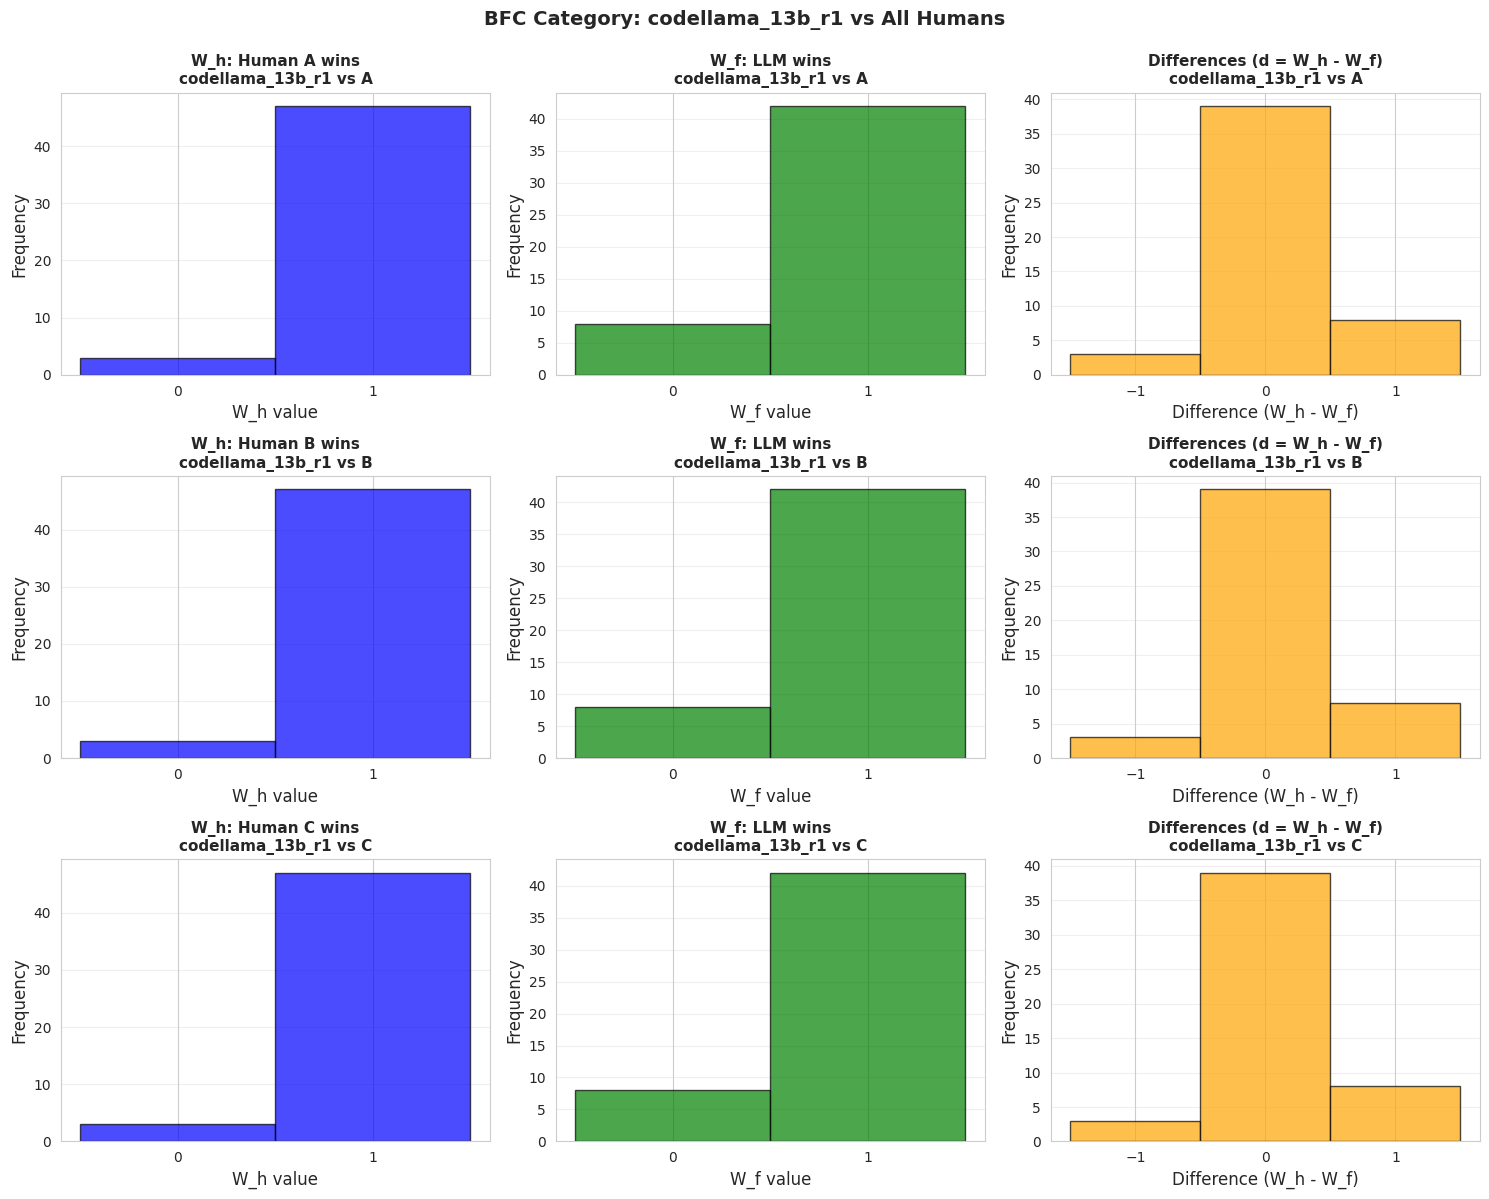


SUMMARY STATISTICS: codellama_13b_r1 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    42/50 commits ( 84.0%)
  Ties:             -39/50 commits (-78.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =  0 (Tie):           39 commits ( 78.0%)
    d =  1 (Human better):   8 commits ( 16.0%)

vs Human B:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    42/50 commits ( 84.0%)
  Ties:             -39/50 commits (-78.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =  0 (Tie):           39 commits ( 78.0%)
    d =  1 (Human better):   8 commits ( 16.0%)

vs Human C:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    42/50 commits ( 84.0%)
  Ties:             -39/50 commits (-78.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =  

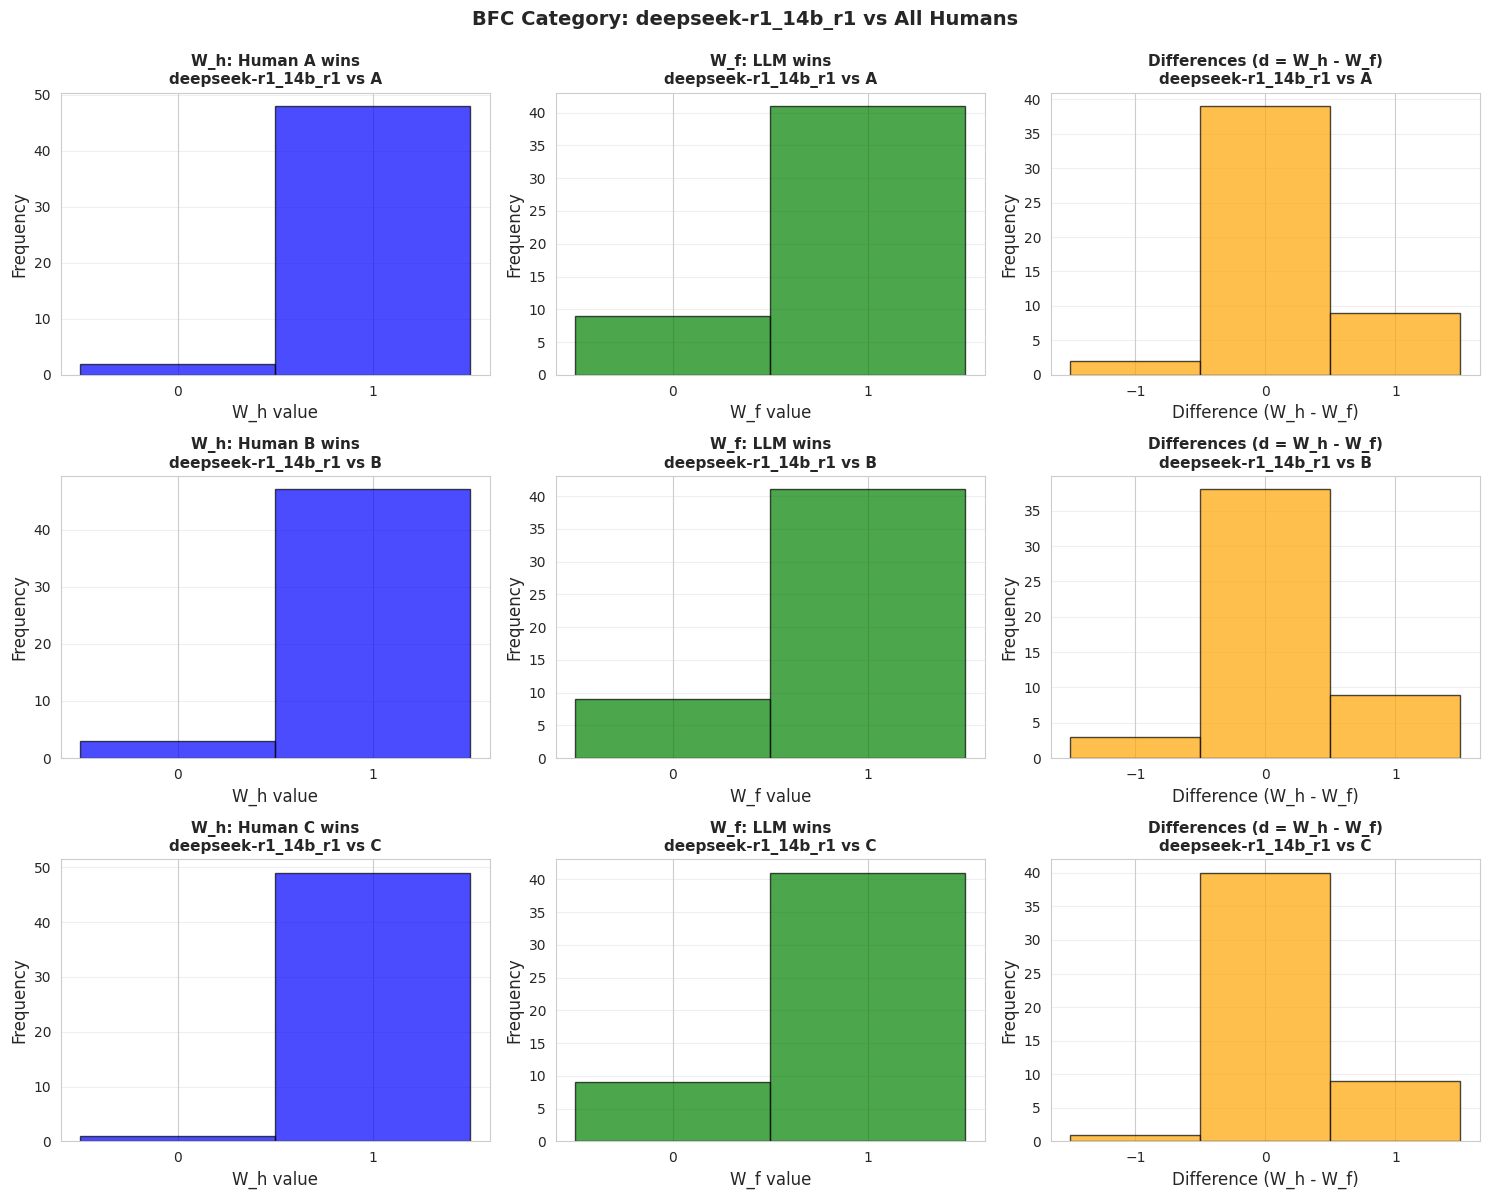


SUMMARY STATISTICS: deepseek-r1_14b_r1 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  48/50 commits ( 96.0%)
  W_f (LLM wins):    41/50 commits ( 82.0%)
  Ties:             -39/50 commits (-78.0%)
  Difference distribution:
    d = -1 (LLM better):     2 commits (  4.0%)
    d =  0 (Tie):           39 commits ( 78.0%)
    d =  1 (Human better):   9 commits ( 18.0%)

vs Human B:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    41/50 commits ( 82.0%)
  Ties:             -38/50 commits (-76.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =  0 (Tie):           38 commits ( 76.0%)
    d =  1 (Human better):   9 commits ( 18.0%)

vs Human C:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    41/50 commits ( 82.0%)
  Ties:             -40/50 commits (-80.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =

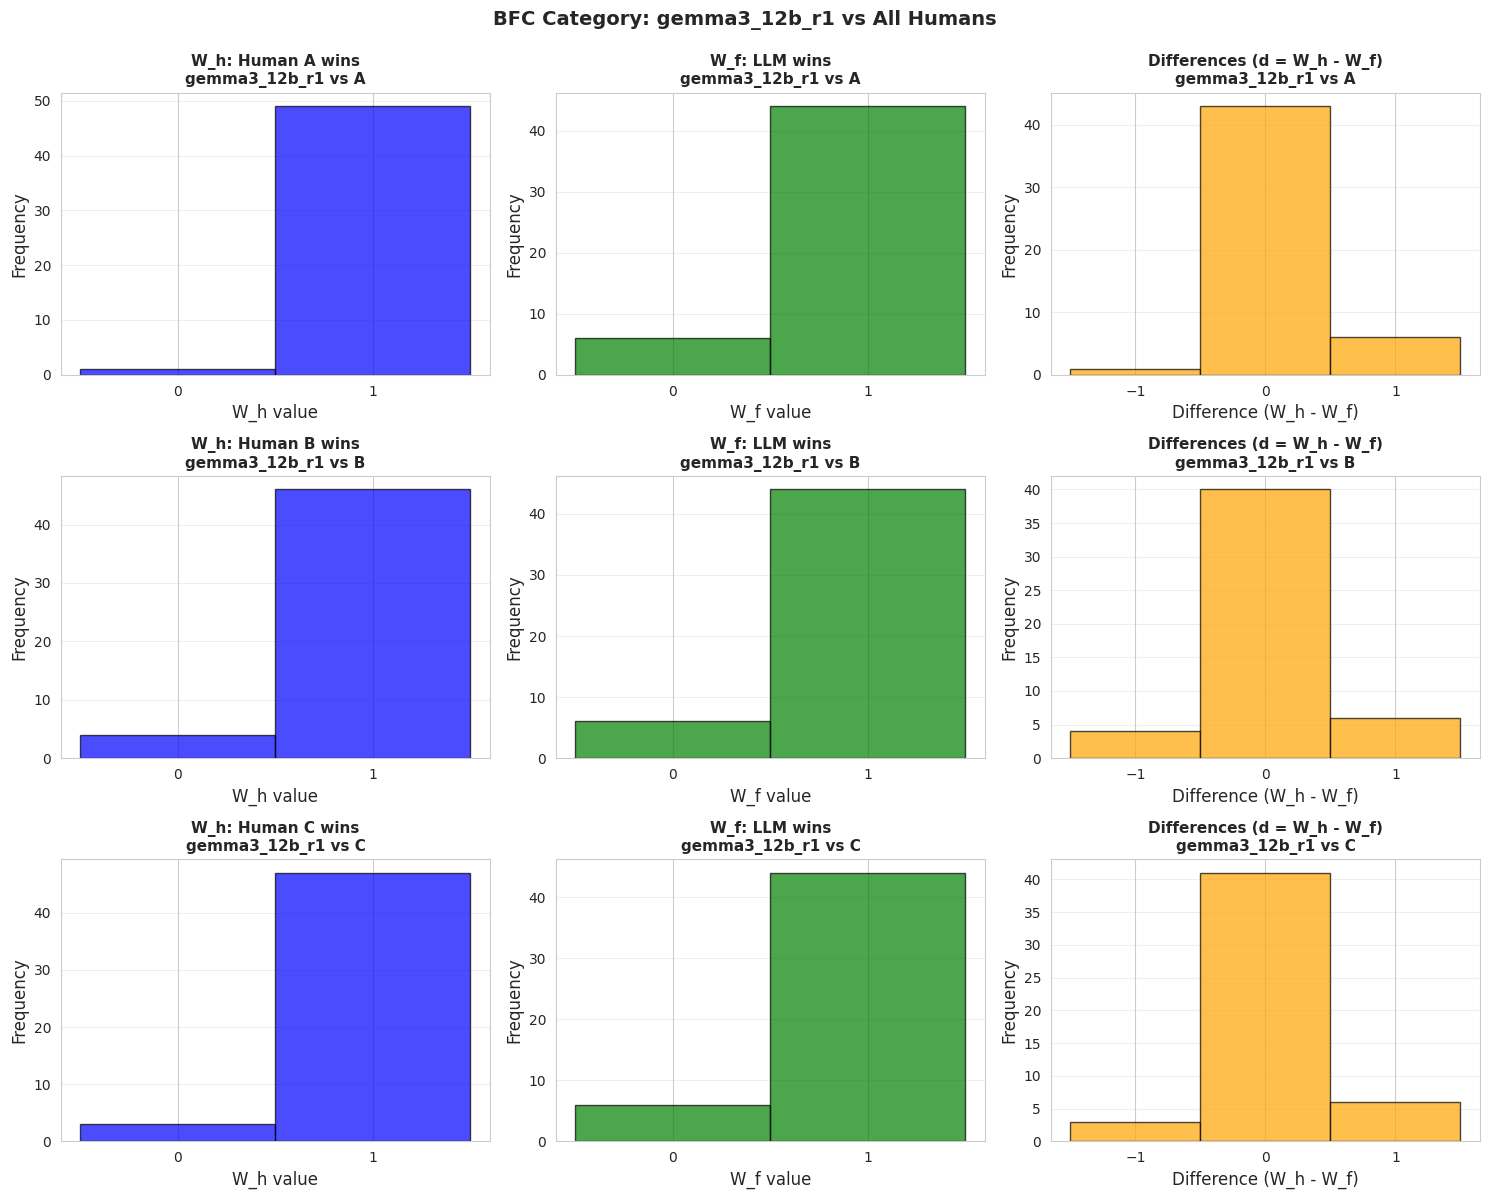


SUMMARY STATISTICS: gemma3_12b_r1 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    44/50 commits ( 88.0%)
  Ties:             -43/50 commits (-86.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0 (Tie):           43 commits ( 86.0%)
    d =  1 (Human better):   6 commits ( 12.0%)

vs Human B:
  W_h (Human wins):  46/50 commits ( 92.0%)
  W_f (LLM wins):    44/50 commits ( 88.0%)
  Ties:             -40/50 commits (-80.0%)
  Difference distribution:
    d = -1 (LLM better):     4 commits (  8.0%)
    d =  0 (Tie):           40 commits ( 80.0%)
    d =  1 (Human better):   6 commits ( 12.0%)

vs Human C:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    44/50 commits ( 88.0%)
  Ties:             -41/50 commits (-82.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =  0 (

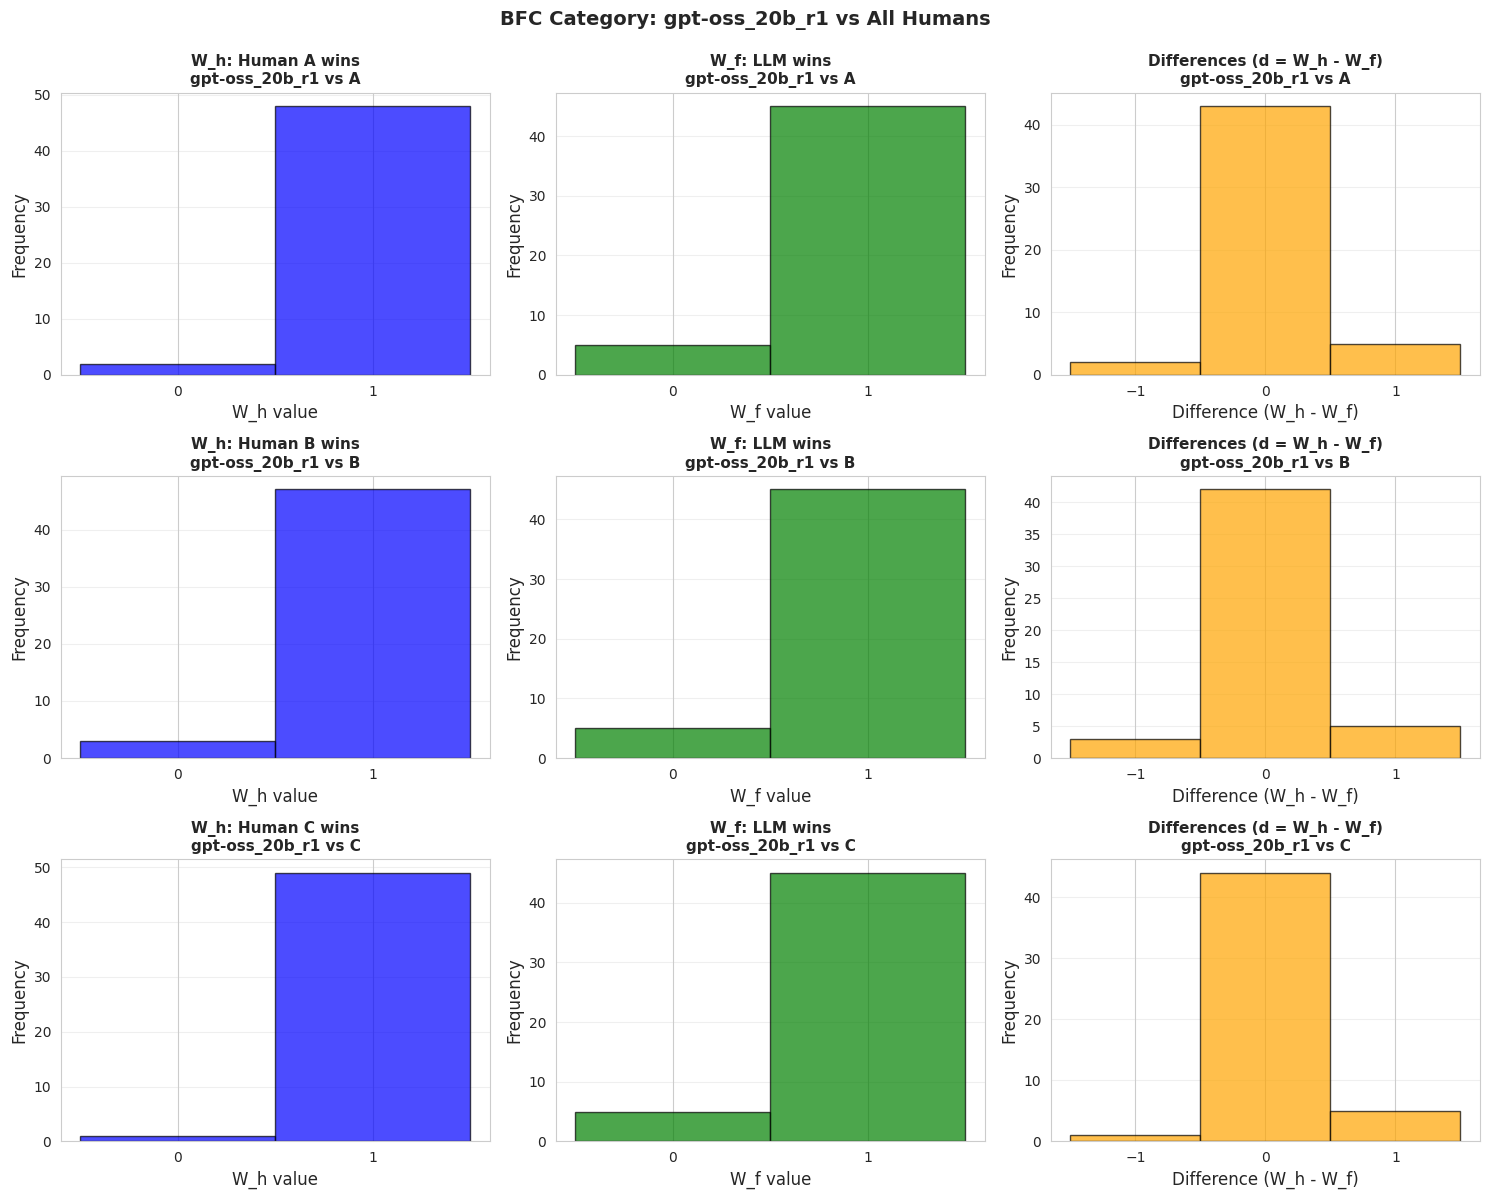


SUMMARY STATISTICS: gpt-oss_20b_r1 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  48/50 commits ( 96.0%)
  W_f (LLM wins):    45/50 commits ( 90.0%)
  Ties:             -43/50 commits (-86.0%)
  Difference distribution:
    d = -1 (LLM better):     2 commits (  4.0%)
    d =  0 (Tie):           43 commits ( 86.0%)
    d =  1 (Human better):   5 commits ( 10.0%)

vs Human B:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    45/50 commits ( 90.0%)
  Ties:             -42/50 commits (-84.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =  0 (Tie):           42 commits ( 84.0%)
    d =  1 (Human better):   5 commits ( 10.0%)

vs Human C:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    45/50 commits ( 90.0%)
  Ties:             -44/50 commits (-88.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0 

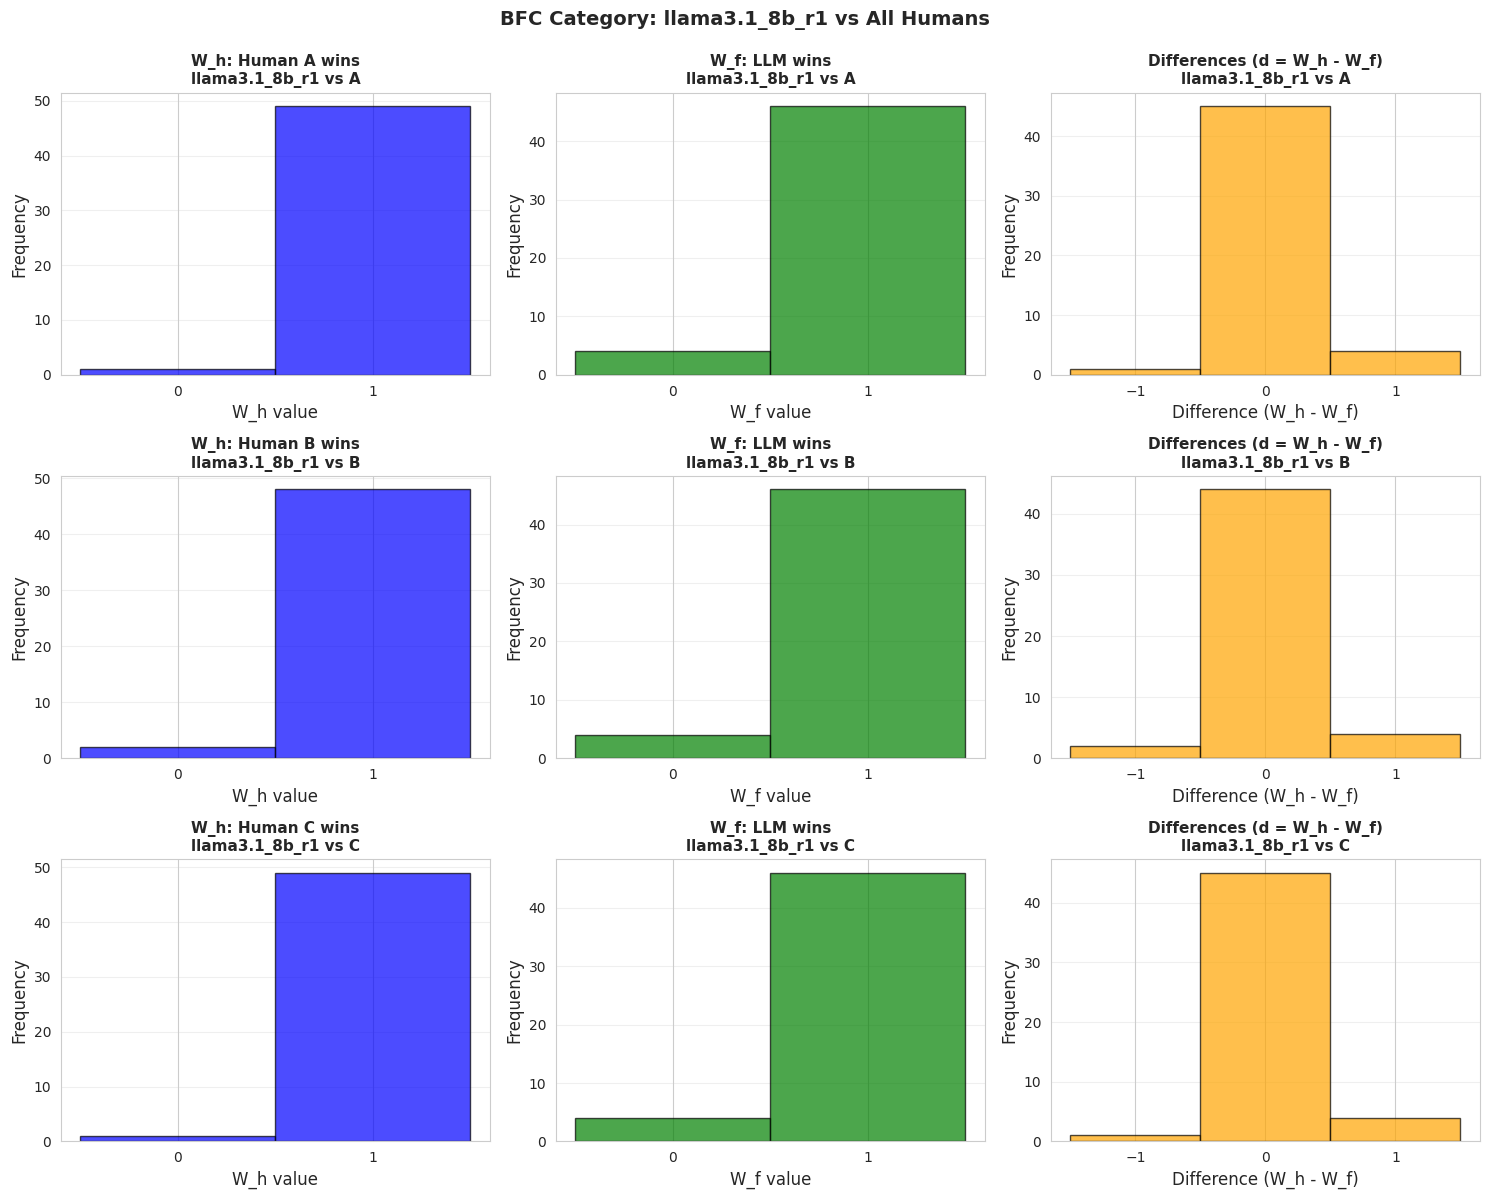


SUMMARY STATISTICS: llama3.1_8b_r1 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    46/50 commits ( 92.0%)
  Ties:             -45/50 commits (-90.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0 (Tie):           45 commits ( 90.0%)
    d =  1 (Human better):   4 commits (  8.0%)

vs Human B:
  W_h (Human wins):  48/50 commits ( 96.0%)
  W_f (LLM wins):    46/50 commits ( 92.0%)
  Ties:             -44/50 commits (-88.0%)
  Difference distribution:
    d = -1 (LLM better):     2 commits (  4.0%)
    d =  0 (Tie):           44 commits ( 88.0%)
    d =  1 (Human better):   4 commits (  8.0%)

vs Human C:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    46/50 commits ( 92.0%)
  Ties:             -45/50 commits (-90.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0 

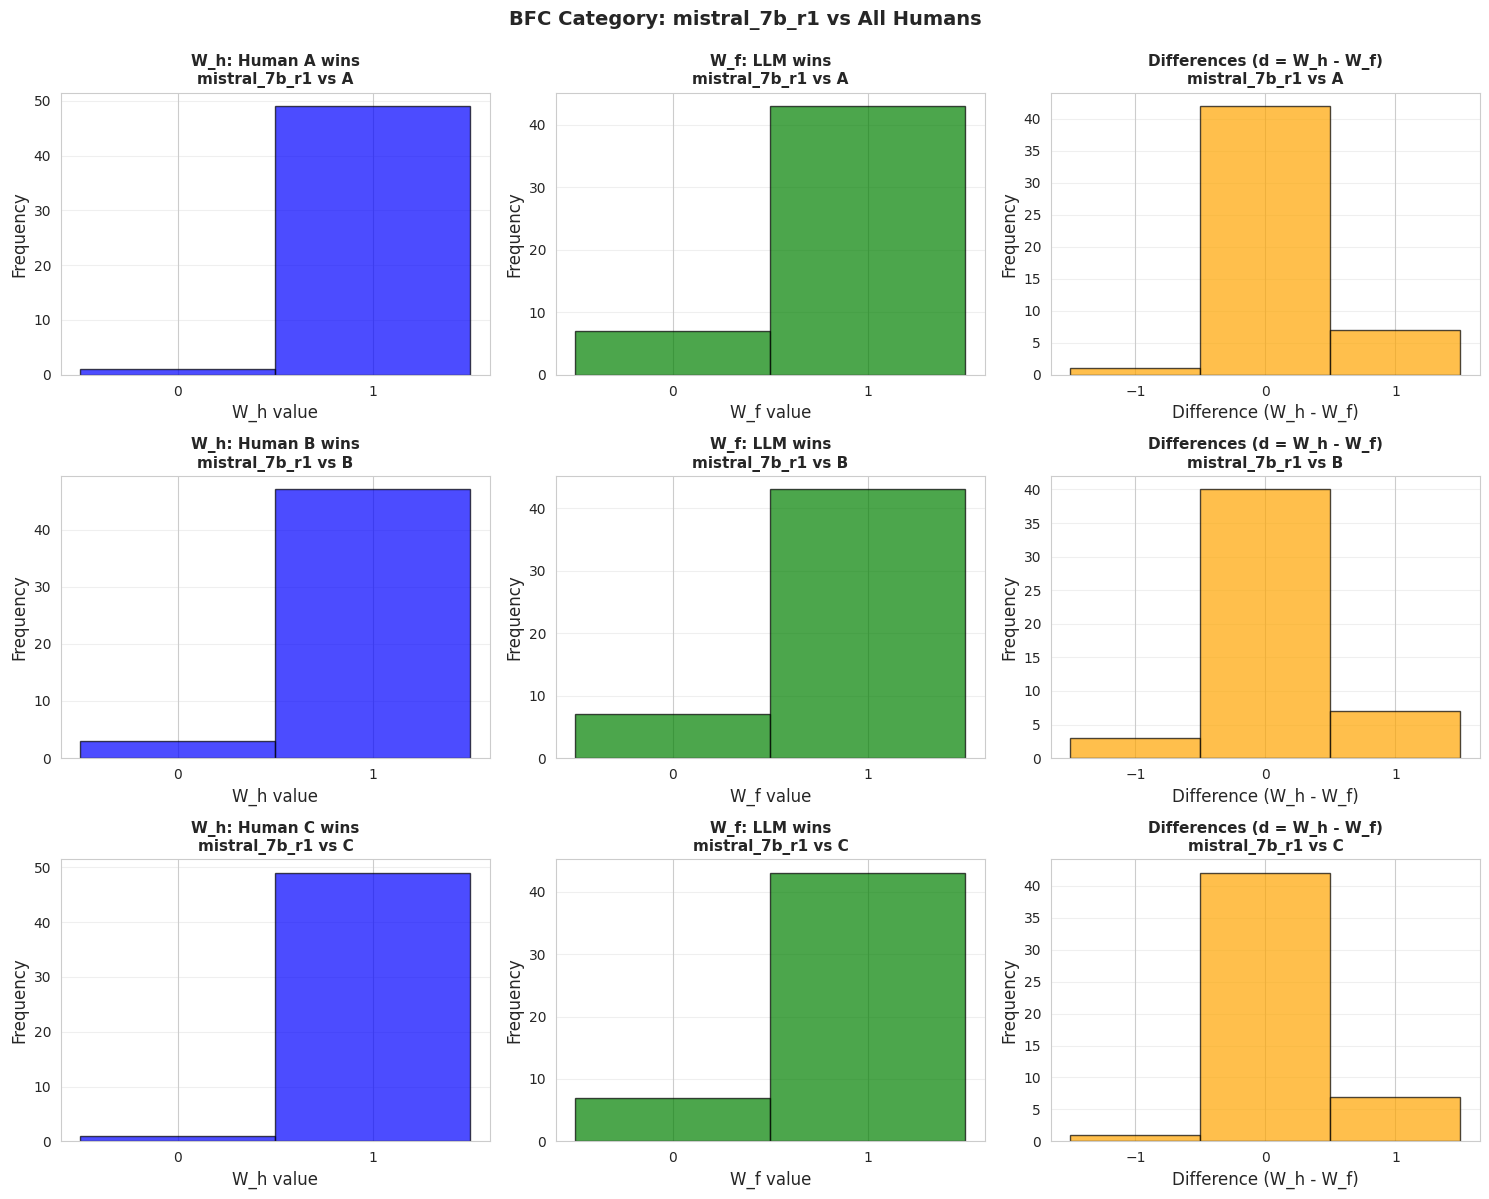


SUMMARY STATISTICS: mistral_7b_r1 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    43/50 commits ( 86.0%)
  Ties:             -42/50 commits (-84.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0 (Tie):           42 commits ( 84.0%)
    d =  1 (Human better):   7 commits ( 14.0%)

vs Human B:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    43/50 commits ( 86.0%)
  Ties:             -40/50 commits (-80.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =  0 (Tie):           40 commits ( 80.0%)
    d =  1 (Human better):   7 commits ( 14.0%)

vs Human C:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    43/50 commits ( 86.0%)
  Ties:             -42/50 commits (-84.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0 (

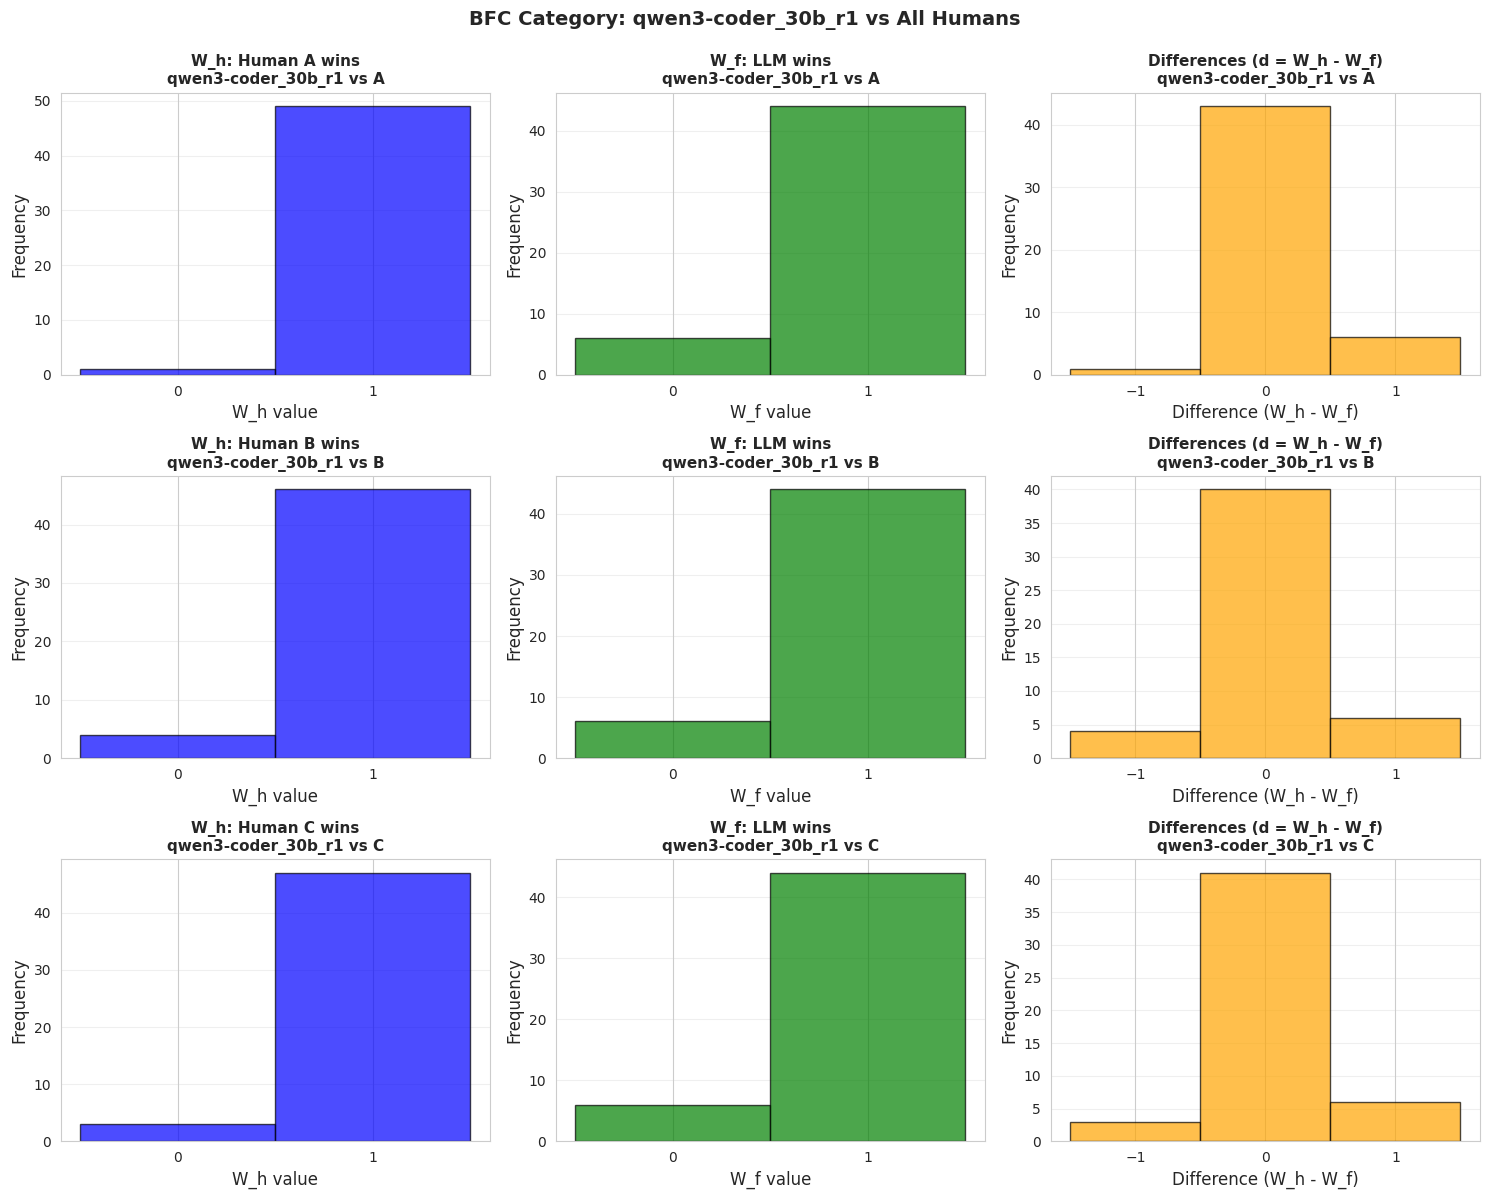


SUMMARY STATISTICS: qwen3-coder_30b_r1 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    44/50 commits ( 88.0%)
  Ties:             -43/50 commits (-86.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0 (Tie):           43 commits ( 86.0%)
    d =  1 (Human better):   6 commits ( 12.0%)

vs Human B:
  W_h (Human wins):  46/50 commits ( 92.0%)
  W_f (LLM wins):    44/50 commits ( 88.0%)
  Ties:             -40/50 commits (-80.0%)
  Difference distribution:
    d = -1 (LLM better):     4 commits (  8.0%)
    d =  0 (Tie):           40 commits ( 80.0%)
    d =  1 (Human better):   6 commits ( 12.0%)

vs Human C:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    44/50 commits ( 88.0%)
  Ties:             -41/50 commits (-82.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =

In [27]:
llm_names = list(llm_data.keys())

for llm_name in llm_names:
    print(f"\n{'='*100}")
    print(f"LLM: {llm_name}")
    print(f"{'='*100}\n")
    
    # Compute advantage probabilities for this LLM
    adv_probs = compute_advantage_probabilities(
        unified_data['bfc'], llm_name, human_annotators
    )
    
    # Create figure for this LLM
    n_humans = len(human_annotators)
    fig, axes = plt.subplots(n_humans, 3, figsize=(15, 4 * n_humans))
    
    # Handle case where there's only one human (axes won't be 2D)
    if n_humans == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (human, res) in enumerate(adv_probs.items()):
        # Histogram of W_h
        axes[idx, 0].hist(res['W_h'], bins=[-0.5, 0.5, 1.5], edgecolor='black', alpha=0.7, color='blue')
        axes[idx, 0].set_xlabel('W_h value', fontsize=12)
        axes[idx, 0].set_ylabel('Frequency', fontsize=12)
        axes[idx, 0].set_title(f'W_h: Human {human} wins\n{llm_name} vs {human}', fontsize=11, fontweight='bold')
        axes[idx, 0].set_xticks([0, 1])
        axes[idx, 0].grid(axis='y', alpha=0.3)
        
        # Histogram of W_f
        axes[idx, 1].hist(res['W_f'], bins=[-0.5, 0.5, 1.5], edgecolor='black', alpha=0.7, color='green')
        axes[idx, 1].set_xlabel('W_f value', fontsize=12)
        axes[idx, 1].set_ylabel('Frequency', fontsize=12)
        axes[idx, 1].set_title(f'W_f: LLM wins\n{llm_name} vs {human}', fontsize=11, fontweight='bold')
        axes[idx, 1].set_xticks([0, 1])
        axes[idx, 1].grid(axis='y', alpha=0.3)
        
        # Histogram of differences (d = W_h - W_f)
        d = np.array(res['W_h']) - np.array(res['W_f'])
        axes[idx, 2].hist(d, bins=[-1.5, -0.5, 0.5, 1.5], edgecolor='black', alpha=0.7, color='orange')
        axes[idx, 2].set_xlabel('Difference (W_h - W_f)', fontsize=12)
        axes[idx, 2].set_ylabel('Frequency', fontsize=12)
        axes[idx, 2].set_title(f'Differences (d = W_h - W_f)\n{llm_name} vs {human}', fontsize=11, fontweight='bold')
        axes[idx, 2].set_xticks([-1, 0, 1])
        axes[idx, 2].grid(axis='y', alpha=0.3)
    
    fig.suptitle(f'BFC Category: {llm_name} vs All Humans', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics for all humans
    print(f"\nSUMMARY STATISTICS: {llm_name} vs All Humans (BFC)")
    print(f"{'-'*80}\n")
    
    for human, res in adv_probs.items():
        d = np.array(res['W_h']) - np.array(res['W_f'])
        n_ties = len(res['W_h']) - np.sum(res['W_h']) - np.sum(res['W_f'])
        
        print(f"vs Human {human}:")
        print(f"  W_h (Human wins): {np.sum(res['W_h']):3d}/{len(res['W_h'])} commits ({res['rho_h']*100:5.1f}%)")
        print(f"  W_f (LLM wins):   {np.sum(res['W_f']):3d}/{len(res['W_f'])} commits ({res['rho_f']*100:5.1f}%)")
        print(f"  Ties:             {n_ties:3d}/{len(res['W_h'])} commits ({n_ties/len(res['W_h'])*100:5.1f}%)")
        print(f"  Difference distribution:")
        print(f"    d = -1 (LLM better):   {np.sum(d == -1):3d} commits ({np.sum(d == -1)/len(d)*100:5.1f}%)")
        print(f"    d =  0 (Tie):          {np.sum(d == 0):3d} commits ({np.sum(d == 0)/len(d)*100:5.1f}%)")
        print(f"    d =  1 (Human better): {np.sum(d == 1):3d} commits ({np.sum(d == 1)/len(d)*100:5.1f}%)")
        print()